# TO DO LISTA *projekt rozpoczęty 12.04.22 r.*
------------------
1. Opis zadania - *description of the task*
2. Uzyskanie danych - *getting the data*
3. Odkryć i zwizuwalizować dane, rozpoznać dodatkowe informacje **BRAK** - *explore data*
4. Przygotować dane pod względem algorytmów maszynowego uczenia - *transform data*
5. Wybrać i wyuczyć model - *choose and learn a model*
6. Dostroić model - *tune the model*
------------------
7. Zaprezentować rozwiązanie (vide - ocena modelu) - *evaluation of the model*
8. Przygotowć potok. Podzielić na katologi produkcyjne. Pokryć sieć testami jednostkowymi - *pipeline*
------------------
9. **Uruchomić (DOCKER | REST API)**, monitorować i utrzymać system./ /Powrót do punktu 2/ - *launch docker*
------------------
W notatniku *ANN_git.ipynb* zawarte jest porównanie sieci: **MinmaxScaler** - **tf MLP** - **MinmaxScaler**, MatlabScaler - tf MLP - MatlabScaler (funkcja). **tf MLP** oraz **MinmaxScaler** zostały utworzone z wag i obciążeń z Matlab,

1. **Opis zadania.** <br>
[12.04] Porównanie wyników uzyskanych w **Matlab i TF**. Trening modelu zgodnie z obecnym stanem wiedzy. Jeżeli wynik **MSE** będzie porównywalny lub nie zostaną stwierdzone mankamenty modelu podstawowego (2k18) [wzrost stanu zagrożenia wraz z brakiem oznak zniszczenia górotworu], wykonany zostanie również krok **7 i 8** <br>
[22.06] uruchomiono SSN z użyciem Docker - zewnętrze skalowanie (normalizacja), danych wejściowych i wyjściowych.<br>
[7.07] Projekt ma na celu porównanie sztucznych sieci neuronowych (wielkowarstwowe perceptrony - **MLP**) oraz wyników uzyskanych w środowiskach **Matlab i TF**. Trening modelu zgodnie z obecnym stanem wiedzy. Jeżeli wynik **MSE** będzie porównywalny lub nie zostaną stwierdzone mankamenty modelu podstawowego (2k18) [wzrost stanu zagrożenia wraz z brakiem oznak zniszczenia górotworu], wykonany zostanie również krok **7 i 8**. Będzie polegać na dwóch etapach: `istniejąca sieć opracowana w Matlab` **etap 1)** `uzyskanie sieć w Keras` obliczenie MSE **etap 2)** ponowne opracowanie i nauczenie sieci w `TF`. Ograniczenie sieci opracowanej w Matlab, polega na zaptrzestaniu rozwijania tzw. płaskich sieci neuronowych. Wykorzystanie `TF` ma na celu użycie technik opracowanych dla potrzeb głębokiego uczenia. Kryterium wyboru nowej sieci będzie `MSE_new > MSE_old` (przy założeniu prawidłowo uzyskanego modelu tj. brak przetrenowania itp.). <br>

2. **Uzyskanie danych**

    dane są nie pełne *(ponowne przeuczenie dla przykładów z lat 2018 - 2022)*
------------------

In [1]:
import pandas as pd
import joblib
# from sklearn.preprocessing import OneHotEncoder
from datetime import datetime
import seaborn as sns
import pandas as pd
import matplotlib.pyplot as plt
import scipy.stats as measures

import keras_tuner as kt

In [4]:
import tensorflow as tf
from tensorflow import keras

In [141]:
pd.read_excel('data_raw.xlsx', sheet_name = 'tabela', engine = 'openpyxl')

,Rodzaj skał stropowych,Wytrzymałość na rozciąganie,Spękania pionowe,Zawodnienie,Płaszczyzny osłabienia,Występowanie zaburzeń zalegania złoża,Średni postęp miesięczny frontu,Średni postęp mieś. likwidacji,"Występowanie zaszłości (stare wyrobiska, zroby)",Głębokość zalegania złoża,Rzeczywista szerokość,Długość kotwi,Dodatkowa obudowa,Czas istnienia wyrobiska,Opadnięcia elementów SRS,Rozwarstwienia stwierdzone badaniem endoskopowym,Predyspozycja,Możliwość utrzymania
0,5,11.80,0.0,0.3,0.0,0.0,18,18,0,1.10,17.5,1.8,0,3.5,0.0,0.0,1.00,1.0
1,4,9.60,0.0,0.3,0.5,0.5,30,30,0,0.85,12.0,1.6,2,6.0,0.0,1.5,1.00,1.0
2,56,9.30,0.0,0.0,0.0,0.6,8,8,75,0.95,11.6,1.8,5,1.0,0.0,0.0,1.00,1.0
3,4,8.70,1.0,0.3,0.0,0.0,0,0,0,1.02,10.0,2.6,3,4.0,0.0,4.6,1.00,1.0
4,4,9.70,0.0,0.0,0.5,1.0,0,0,0,0.74,7.0,1.8,0,6.0,0.0,2.0,1.00,1.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
75,4,8.59,0.0,0.0,0.0,0.0,15,15,35,1.11,7.0,1.8,0,2.0,0.0,0.5,0.60,0.5
76,4,8.59,0.0,0.0,0.0,0.0,15,15,35,1.11,7.0,1.8,0,3.0,0.0,0.3,0.60,0.5
77,4,8.59,1.0,0.0,0.0,0.0,15,15,21,1.11,7.0,1.8,0,3.0,0.0,0.0,0.45,0.5
78,4,10.80,1.0,0.0,0.0,0.0,15,15,21,1.11,7.0,1.8,0,3.0,0.0,0.5,0.60,0.5


In [4]:
data = pd.read_csv('data_.csv', index_col = False)
data.head()

,TOP,Rr,CRv,HYDRO,WEAK,TECT,v_FR,v_LI,ZROBY,H,W,L,EXT,T,SRS,ENDO,CRFp,CRFm
0,5,11.8,0.0,0.3,0.0,0.0,18,18,0,1.10,17.5,1.8,0,3.5,0.0,0.0,1.0,1.0
1,4,9.6,0.0,0.3,0.5,0.5,30,30,0,0.85,12.0,1.6,2,6.0,0.0,1.5,1.0,1.0
2,56,9.3,0.0,0.0,0.0,0.6,8,8,75,0.95,11.6,1.8,5,1.0,0.0,0.0,1.0,1.0
3,4,8.7,1.0,0.3,0.0,0.0,0,0,0,1.02,10.0,2.6,3,4.0,0.0,4.6,1.0,1.0
4,4,9.7,0.0,0.0,0.5,1.0,0,0,0,0.74,7.0,1.8,0,6.0,0.0,2.0,1.0,1.0


In [5]:
data.describe()

,TOP,Rr,CRv,HYDRO,WEAK,TECT,v_FR,v_LI,ZROBY,H,W,L,EXT,T,SRS,ENDO,CRFp,CRFm
count,80.00000,80.000000,80.000000,80.000000,80.000000,80.000000,80.000000,80.000000,80.000000,80.000000,80.000000,80.00000,80.000000,80.000000,80.00000,80.000000,80.000000,80.000000
mean,13.36250,8.735250,0.468750,0.160000,0.162500,0.167500,11.512500,13.075000,62.800000,1.108687,7.695000,1.82500,1.237500,3.618875,0.34750,1.051875,0.645625,0.650000
std,19.05106,1.452321,0.452446,0.281767,0.235665,0.291992,8.236986,9.815739,48.310546,0.084174,1.619728,0.15711,5.102106,1.961915,0.35166,1.053188,0.193681,0.225018
min,2.00000,5.400000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.600000,6.400000,1.60000,0.000000,0.500000,0.00000,0.000000,0.400000,0.300000
25%,4.00000,8.000000,0.000000,0.000000,0.000000,0.000000,5.000000,5.000000,21.000000,1.110000,7.000000,1.80000,0.000000,2.000000,0.00000,0.000000,0.450000,0.500000
50%,5.00000,9.000000,0.500000,0.000000,0.000000,0.000000,15.000000,15.000000,60.000000,1.110000,7.000000,1.80000,0.000000,3.000000,0.25000,1.050000,0.600000,0.500000
75%,6.00000,9.600000,1.000000,0.300000,0.500000,0.425000,20.000000,20.000000,90.000000,1.150000,7.575000,1.80000,1.000000,6.000000,0.50000,1.800000,0.800000,0.900000
max,56.00000,11.800000,1.000000,1.000000,0.500000,1.000000,30.000000,50.000000,190.000000,1.175000,17.500000,2.60000,45.000000,7.000000,1.00000,4.600000,1.000000,1.000000


3. Odkryć i zwizuwalizować dane, rozpoznać dodatkowe informacje
------------------

array([[<AxesSubplot:title={'center':'TOP'}>,
        <AxesSubplot:title={'center':'Rr'}>,
        <AxesSubplot:title={'center':'CRv'}>,
        <AxesSubplot:title={'center':'HYDRO'}>],
       [<AxesSubplot:title={'center':'WEAK'}>,
        <AxesSubplot:title={'center':'TECT'}>,
        <AxesSubplot:title={'center':'v_FR'}>,
        <AxesSubplot:title={'center':'v_LI'}>],
       [<AxesSubplot:title={'center':'ZROBY'}>,
        <AxesSubplot:title={'center':'H'}>,
        <AxesSubplot:title={'center':'W'}>,
        <AxesSubplot:title={'center':'L'}>],
       [<AxesSubplot:title={'center':'EXT'}>,
        <AxesSubplot:title={'center':'T'}>,
        <AxesSubplot:title={'center':'SRS'}>,
        <AxesSubplot:title={'center':'ENDO'}>],
       [<AxesSubplot:title={'center':'CRFp'}>,
        <AxesSubplot:title={'center':'CRFm'}>, <AxesSubplot:>,
        <AxesSubplot:>]], dtype=object)

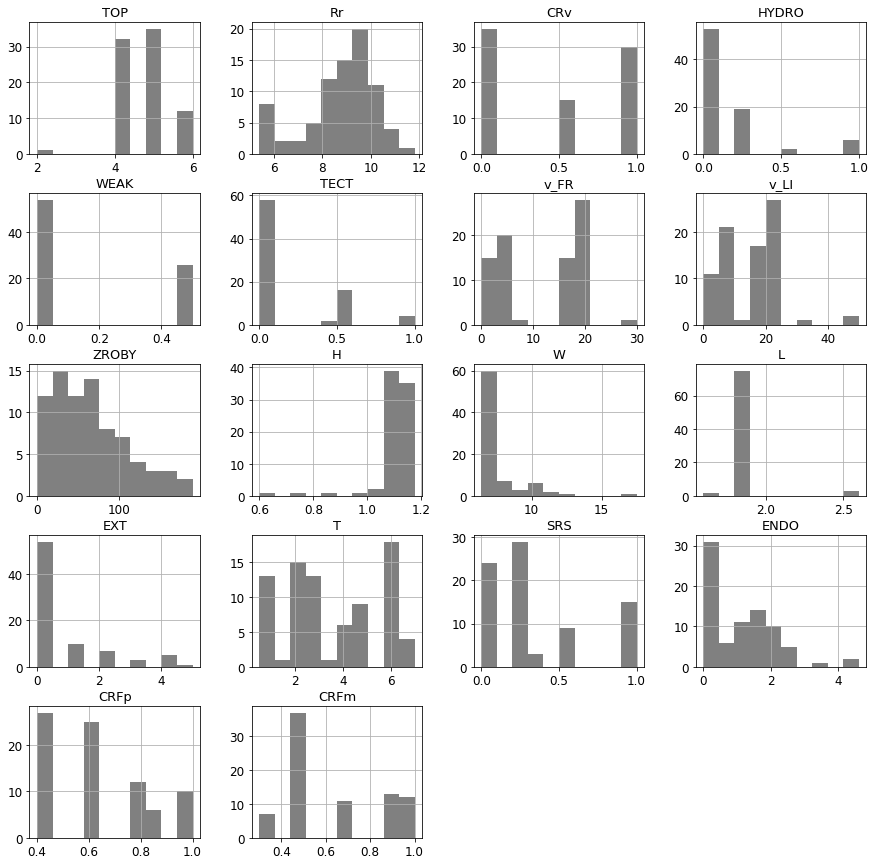

In [23]:
plt.rc('font', size=13)
plt.rc('axes', labelsize=14, titlesize=13)
plt.rc('legend', fontsize=13)
plt.rc('xtick', labelsize=12)
plt.rc('ytick', labelsize=12)
data.hist(figsize=(15,15), color = 'grey')

In [51]:
data.EXT.value_counts()/len(data) # cat_proportions

0    0.6750
1    0.1250
2    0.0875
4    0.0625
3    0.0375
5    0.0125
Name: EXT, dtype: float64

array([[<AxesSubplot:xlabel='TOP', ylabel='TOP'>,
        <AxesSubplot:xlabel='Rr', ylabel='TOP'>,
        <AxesSubplot:xlabel='CRv', ylabel='TOP'>,
        <AxesSubplot:xlabel='HYDRO', ylabel='TOP'>,
        <AxesSubplot:xlabel='WEAK', ylabel='TOP'>,
        <AxesSubplot:xlabel='TECT', ylabel='TOP'>,
        <AxesSubplot:xlabel='v_FR', ylabel='TOP'>,
        <AxesSubplot:xlabel='v_LI', ylabel='TOP'>,
        <AxesSubplot:xlabel='ZROBY', ylabel='TOP'>,
        <AxesSubplot:xlabel='H', ylabel='TOP'>,
        <AxesSubplot:xlabel='W', ylabel='TOP'>,
        <AxesSubplot:xlabel='L', ylabel='TOP'>,
        <AxesSubplot:xlabel='EXT', ylabel='TOP'>,
        <AxesSubplot:xlabel='T', ylabel='TOP'>,
        <AxesSubplot:xlabel='SRS', ylabel='TOP'>,
        <AxesSubplot:xlabel='ENDO', ylabel='TOP'>,
        <AxesSubplot:xlabel='CRFp', ylabel='TOP'>,
        <AxesSubplot:xlabel='CRFm', ylabel='TOP'>],
       [<AxesSubplot:xlabel='TOP', ylabel='Rr'>,
        <AxesSubplot:xlabel='Rr', ylabel='Rr'>,


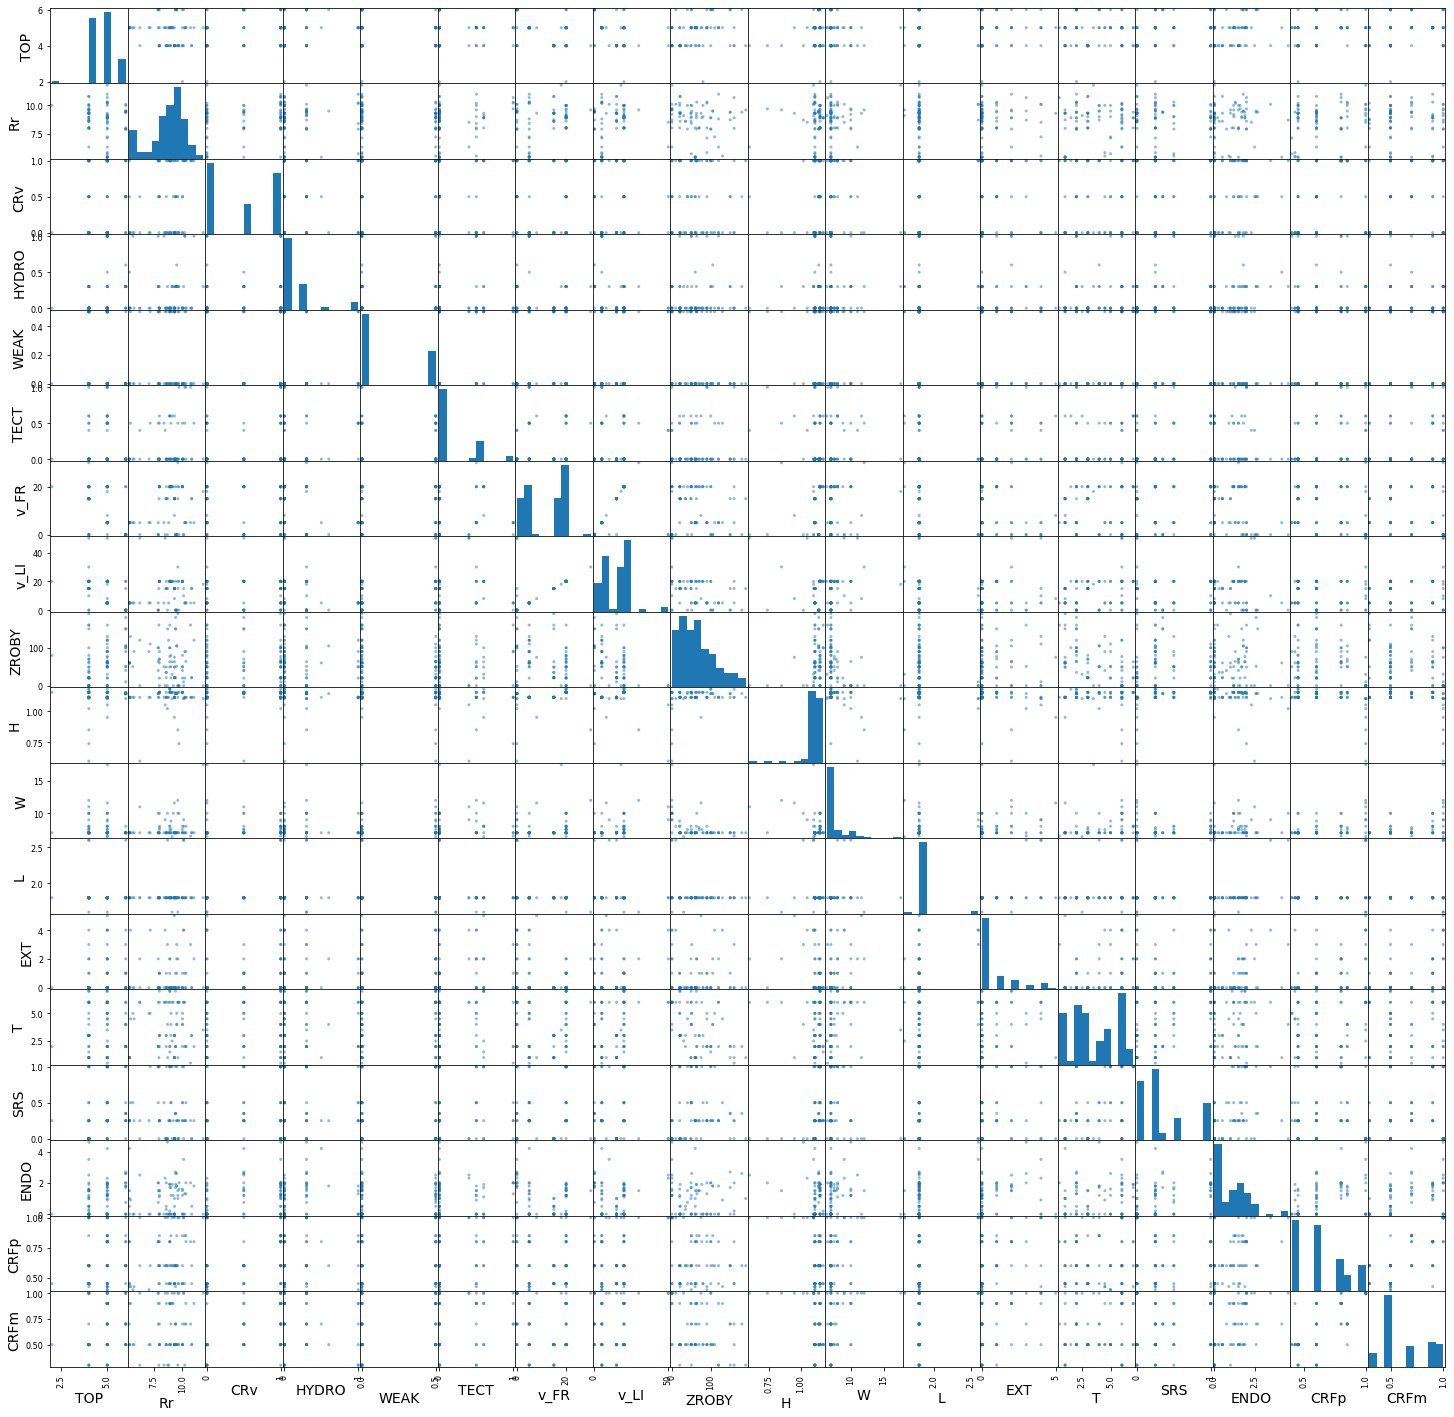

In [57]:
pd.plotting.scatter_matrix(
    data,
    figsize = (25,25)
)

4. **Przygotować dane pod względem algorytmów maszynowego uczenia** 
* uporządkować cechy typy CATEGORY:
    - określić martwe parametry,
    - rodzaj skał (wg Rr i Rc, usunąć 1),
* dodać kodowanie gorącojedynkowe
* standaryzacja
* podzielić zbiory
------------------

* martwe parametry <br>
1: brak 1,3,7 <br>
4: za dużo o 0,5

In [22]:
# dodać kodowanie gorącojedynkowe
data.TOP.replace({56:5, 54:5}, inplace = True)         # zamiana 56 i 54 na 5 - redukuje macierz CatOneHot z 6 kolumn do 4 !
data.EXT.replace({45:4}, inplace = True)         # zamiana 56 i 54 na 5 - redukuje macierz CatOneHot z 6 kolumn do 4 !

#cat_encoder = OneHotEncoder()
#data_hot_1enc = cat_encoder.fit_transform(data[["TOP"]])
#data_hot_1enc.toarray()

In [20]:
CRFp = data[['CRFp']]
CRFm = data[['CRFm']]
data_p = data[["TOP","Rr","CRv","HYDRO","WEAK","TECT","v_FR","v_LI","ZROBY","H","SRS","ENDO"]]
#data_m = data[["TOP","Rr","CRv","HYDRO","WEAK","TECT","v_FR","v_LI","ZROBY","H",'W',"L","EXT","T","SRS","ENDO"]]

In [21]:
import numpy as np
from sklearn.model_selection import train_test_split

In [22]:
X_train, X_test, y_train, y_test = train_test_split(
    data_p, CRFp, test_size=0.10, random_state=42)

[x.shape for x in [X_train, X_test, y_train, y_test]]

#X_train.shape[1:]

[(72, 12), (8, 12), (72, 1), (8, 1)]

## standaryzacja sklearn

In [11]:
from sklearn.preprocessing import StandardScaler

In [149]:
scaler = StandardScaler()

In [150]:
scaler.fit(data_p)

StandardScaler()

In [12]:
X_train = scaler.transform(X_train)
X_test = scaler.transform(X_test)

NameError: name 'scaler' is not defined

In [152]:
X_train

array([[-9.35684378e-01,  6.68472755e-01, -1.04257207e+00,
        -5.71428571e-01,  1.44115338e+00,  2.86909095e+00,
        -1.40647737e+00, -1.34044852e+00, -1.30812470e+00,
        -4.40769288e+00, -9.94405766e-01,  9.05922566e-01],
       [ 1.69079809e+00, -5.78742543e-01,  6.95048047e-02,
         5.00000000e-01,  1.44115338e+00, -5.77264545e-01,
        -1.40647737e+00, -1.34044852e+00, -4.74924253e-01,
         3.74343810e-01,  4.36393897e-01, -2.88438101e-01],
       [ 3.77556854e-01, -5.09452804e-01,  1.18158168e+00,
        -5.71428571e-01,  1.44115338e+00, -5.77264545e-01,
         1.03691437e+00,  7.09950744e-01, -1.30812470e+00,
         4.93894727e-01, -2.79005934e-01,  1.41531739e-01],
       [-9.35684378e-01,  8.76341971e-01,  6.95048047e-02,
        -5.71428571e-01, -6.93888666e-01, -5.77264545e-01,
         1.03691437e+00,  7.09950744e-01, -4.74924253e-01,
         4.93894727e-01,  1.86719356e+00,  4.28178299e-01],
       [ 3.77556854e-01, -1.06377071e+00, -1.0425720

In [23]:
from sklearn.preprocessing import MinMaxScaler

scalerMinMax = MinMaxScaler(feature_range=(-1, 1))
scalerMinMax.fit(data_p)
X_train = scalerMinMax.transform(X_train)
X_test = scalerMinMax.transform(X_test)

# 5. Wybrać i wyuczyć model 
------------------------------------

In [154]:
#need: import tensorflow as tf
#need: from tensorflow import keras

In [155]:
tf.__version__

'2.8.0'

In [170]:
list_output = hold_data() # saved model output to common list

In [13]:
model = keras.models.Sequential()
#model.add(keras.Input(shape=(12,)))
model.add(keras.layers.Dense(7, activation = 'relu', input_shape = (12,), kernel_initializer = 'he_normal'))
model.add(keras.layers.Dense(4, activation = 'relu', kernel_initializer = 'he_normal'))
model.add(keras.layers.Dense(1))
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 7)                 91        
                                                                 
 dense_1 (Dense)             (None, 4)                 32        
                                                                 
 dense_2 (Dense)             (None, 1)                 5         
                                                                 
Total params: 128
Trainable params: 128
Non-trainable params: 0
_________________________________________________________________


In [169]:
#model.layers

In [32]:
#weights, biases = model.layers[1].get_weights()
#weights, biases

In [33]:
"""import tensorflow_probability as tfp

def pearson_(x,y):
    return tfp.stats.correlation(x,y)"""

'import tensorflow_probability as tfp\n\ndef pearson_(x,y):\n    return tfp.stats.correlation(x,y)'

In [14]:
model.compile(loss = 'mean_squared_error',
             optimizer = 'SGD',
             metrics = ["MAE"])

In [158]:
X_train.shape

(72, 12)

In [159]:
history = model.fit(X_train, y_train, epochs = 100,
                    validation_split = 0.2, shuffle = True) #steps_per_epoch=32 

Epoch 1/100
2/2 [==============================] - 1s 154ms/step - loss: 7.2698 - MAE: 1.5491 - val_loss: 0.4369 - val_MAE: 0.5443
Epoch 2/100
2/2 [==============================] - 0s 19ms/step - loss: 0.3534 - MAE: 0.4923 - val_loss: 0.3920 - val_MAE: 0.5077
Epoch 3/100
2/2 [==============================] - 0s 28ms/step - loss: 0.3174 - MAE: 0.4612 - val_loss: 0.3571 - val_MAE: 0.4755
Epoch 4/100
2/2 [==============================] - 0s 21ms/step - loss: 0.2863 - MAE: 0.4327 - val_loss: 0.3321 - val_MAE: 0.4570
Epoch 5/100
2/2 [==============================] - 0s 27ms/step - loss: 0.2644 - MAE: 0.4115 - val_loss: 0.3119 - val_MAE: 0.4406
Epoch 6/100
2/2 [==============================] - 0s 26ms/step - loss: 0.2472 - MAE: 0.3949 - val_loss: 0.2962 - val_MAE: 0.4290
Epoch 7/100
2/2 [==============================] - 0s 133ms/step - loss: 0.2325 - MAE: 0.3806 - val_loss: 0.2828 - val_MAE: 0.4192
Epoch 8/100
2/2 [==============================] - 0s 26ms/step - loss: 0.2194 - MAE: 0.

In [171]:
list_output.add_out(*['model', 0.15 , "random ini",' - - ',"loss: 0.0401 - MAE: 0.1586 - val_loss: 0.0564 - val_MAE: 0.1963",'Podstawowy'])
" 'NET','MAX_MSE','TUNER_KERAS','OTHER', 'EXTRAS#1','EXTRAS#2' "

Added:  ['model', 0.15, 'random ini', ' - - ', 'loss: 0.0401 - MAE: 0.1586 - val_loss: 0.0564 - val_MAE: 0.1963', 'Podstawowy']


" 'NET','MAX_MSE','TUNER_KERAS','OTHER', 'EXTRAS#1','EXTRAS#2' "

In [172]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 7)                 91        
                                                                 
 dense_1 (Dense)             (None, 4)                 32        
                                                                 
 dense_2 (Dense)             (None, 1)                 5         
                                                                 
Total params: 128
Trainable params: 128
Non-trainable params: 0
_________________________________________________________________


In [3]:
# #_2 check influence of the number of neurons, given optimizer and model.compile  -> plot_train_via_neurons(foo), compute()
def foo(NEURONS):
    model = keras.models.Sequential()
    #model.add(keras.Input(shape=(12,)))
    model.add(keras.layers.Dense(NEURONS, activation = 'relu', input_shape = (12,), kernel_initializer = 'he_normal'))
    model.add(keras.layers.Dense(NEURONS, activation = 'relu', kernel_initializer = 'he_normal'))
    model.add(keras.layers.Dense(1))
    optimizer = keras.optimizers.Adam(learning_rate = 0.01, beta_1=0.9, beta_2 = 0.999)
    model.compile(loss = "MAE",
                 optimizer = optimizer,
                 metrics = ["MAE"])
    return model

test_ = plot_train_via_neurons(foo, scalerMinMax, (data_p, CRFp))
test_.compute(X_train, y_train, epochs = 30, validation_split = 0.2, shuffle = True, verbose=0)

NameError: name 'plot_train_via_neurons' is not defined

In [ ]:
list_output.add_out(*['model_n_neurons', 0.75 , "random ini",'plot_train_via_neurons',"średnia:  0.719 max:  0.787",'struktura:  [8, 8, 1]'])

Added:  ['model_n_neurons', 0.75, 'random ini', 'plot_train_via_neurons', 'średnia:  0.719 max:  0.787', 'struktura:  [8, 8, 1]']


In [ ]:
def huber_fn(y_true, y_pred):
    error = y_true - y_pred
    is_small_error = tf.abs(error) < 1
    squared_loss = tf.square(error) /2 
    linear_loss = tf.abs(error) - 0.5
    return tf.where(is_small_error, squared_loss, linear_loss)

In [ ]:
def foo_hb(NEURONS):
    model = keras.models.Sequential()
    #model.add(keras.Input(shape=(12,)))
    model.add(keras.layers.Dense(NEURONS, activation = 'relu', input_shape = (12,), kernel_initializer = 'he_normal'))
    model.add(keras.layers.Dense(NEURONS, activation = 'relu', kernel_initializer = 'he_normal'))
    model.add(keras.layers.Dense(1))
    optimizer = keras.optimizers.Adam(learning_rate = 0.01, beta_1=0.9, beta_2 = 0.999)
    model.compile(loss = huber_fn,
                 optimizer = optimizer,
                 metrics = ["MAE"])
    return model

[0.7252705039284171, 0.4151339786626651, 0.7110917452915443] średnia:  0.617 max:  0.725 struktura:  [6, 6, 1]
[0.6837896320336944, 0.45520940885337724, 0.34452600136068134] średnia:  0.495 max:  0.684 struktura:  [7, 7, 1]
[0.7061006739474021, 0.36606810046885324, 0.839438535240854] średnia:  0.637 max:  0.839 struktura:  [8, 8, 1]
[0.6295374294878933, 0.8423851254863987, 0.7560235720044708] średnia:  0.743 max:  0.842 struktura:  [9, 9, 1]


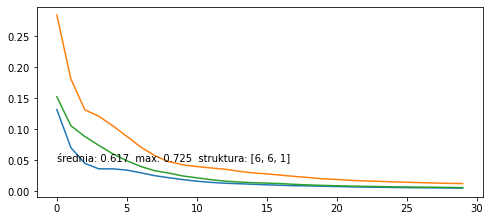

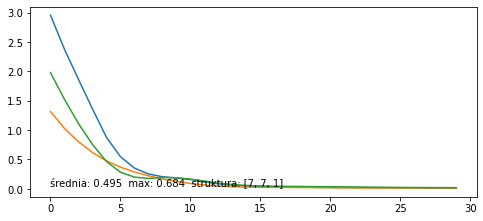

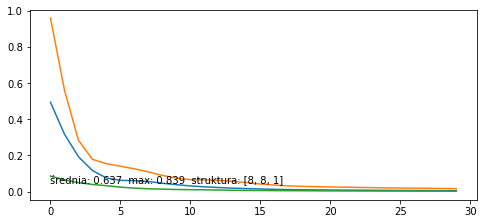

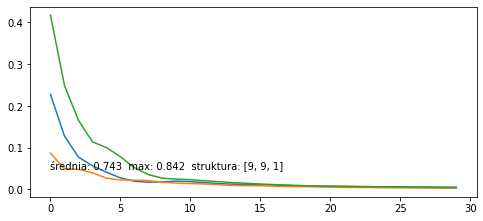

In [ ]:
test_hb_ = plot_train_via_neurons(foo_hb, scalerMinMax, (data_p, CRFp))
test_hb_.compute(X_train, y_train, epochs = 30, validation_split = 0.2, shuffle = True, verbose=0)

In [ ]:
list_output.add_out(*['model_n_neurons', 0.84 , "random ini + hb fn",'plot_train_via_neurons',"średnia:  0.743 max:  0.8427",'struktura:  [9, 9, 1]'])

Added:  ['model_n_neurons', 0.84, 'random ini + hb fn', 'plot_train_via_neurons', 'średnia:  0.743 max:  0.8427', 'struktura:  [9, 9, 1]']


Using the Huber activation function increased the value of the metric from `0.15 to 0.84 (MAE)`

[0.4671248675850302, 0.2898966406041157, 0.7324508346800744] średnia:  0.496 max:  0.732 struktura:  [6, 6, 1]
[0.49728850358110666, 0.6857909775369149, 0.5242497807695181] średnia:  0.569 max:  0.686 struktura:  [7, 7, 1]
[0.6366307063069008, 0.48000510751441444, 0.7551090668683624] średnia:  0.624 max:  0.755 struktura:  [8, 8, 1]
[0.7580715658393006, 0.7812007363939205, 0.7165930975566935] średnia:  0.752 max:  0.781 struktura:  [9, 9, 1]


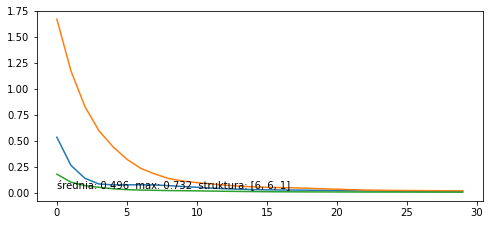

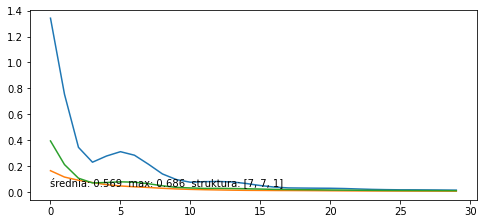

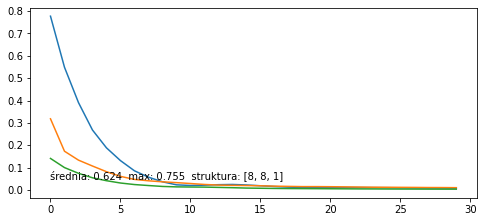

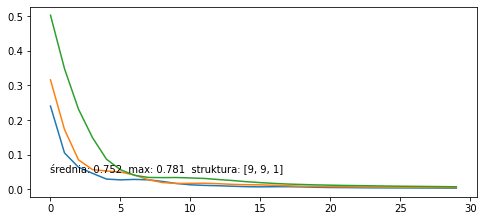

In [ ]:
# let's try output distribution
test_hb_ = plot_train_via_neurons(foo_hb, scalerMinMax, (data_p, CRFp))
test_hb_.compute(X_train, y_train, epochs = 30, validation_split = 0.2, shuffle = True, verbose=0)

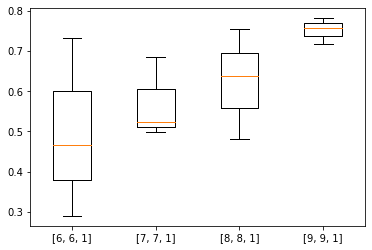

In [ ]:
test_hb_.plot_box()

In [ ]:
list_output.print_()

               NET  MAX_MSE         TUNER_KERAS                   OTHER  \
0            model     0.15          random ini                    - -    
1  model_n_neurons     0.75          random ini  plot_train_via_neurons   
2  model_n_neurons     0.75  random ini + hb fn  plot_train_via_neurons   
3  model_n_neurons     0.84  random ini + hb fn  plot_train_via_neurons   

                                            EXTRAS#1               EXTRAS#2  
0  loss: 0.0401 - MAE: 0.1586 - val_loss: 0.0564 ...             Podstawowy  
1                        średnia:  0.719 max:  0.787  struktura:  [8, 8, 1]  
2                       średnia:  0.743 max:  0.8427  struktura:  [9, 9, 1]  
3                       średnia:  0.743 max:  0.8427  struktura:  [9, 9, 1]  


Three times repeated prediction made for four structures. Best result for 9 neurons (also upper limit of the test). This proves the necessity to re-test for a larger scope (10, 11 and 12 neuronos). Experience shows that it may have too many degrees of freedom.
Additionally, an increase in the number of neurons reduces the variance (*vide* - box plot). Which increases the repeatability of a better result. Learning curves don't look bad. 

The mean and the maximum value of MAE are similar for the `MAE` and `Huber_fn` functions, but in the second case, the learning curves are smoother

# BRAK DANYCH WALIDACYJNYCH !!!!

6. Dostroić model
------------------

In [ ]:
# CLASSIC STYLE (Seq)
model = keras.models.Sequential()
model.add(keras.layers.Dense(7, activation = 'relu', input_shape = (12,), kernel_initializer = 'he_normal'))
model.add(keras.layers.Dense(4, activation = 'relu', kernel_initializer = 'he_normal'))
model.add(keras.layers.Dense(1))


Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 7)                 91        
                                                                 
 dense_1 (Dense)             (None, 4)                 32        
                                                                 
 dense_2 (Dense)             (None, 1)                 5         
                                                                 
Total params: 128
Trainable params: 128
Non-trainable params: 0
_________________________________________________________________


In [ ]:
model.compile(loss = 'mean_squared_error',
             optimizer = 'SGD',
             metrics = ["MAE"])

In [ ]:
history = model.fit(X_train, y_train, epochs = 100,
                    validation_split = 0.2, shuffle = True)

## keras_tuner

In [ ]:
import keras_tuner as kt

In [ ]:
# need: import keras_tuner as kt

def build_model(hp):
    n_hidden = hp.Int("n_hidden", min_value=0, max_value=4, default=2)
    n_neurons = hp.Int("n_neurons", min_value=3, max_value=11)
    learning_rate = hp.Float("learning_rate", min_value=1e-4, max_value=1e-2,
                             sampling="log")
    optimizer = hp.Choice("optimizer", values=["sgd", "adam"])
    
    optimizer = {
        'sgd': tf.keras.optimizers.SGD(learning_rate=learning_rate),
        'adam': tf.keras.optimizers.Adam(learning_rate=learning_rate)
    }.get(optimizer)
    

    model = tf.keras.Sequential()
    model.add(tf.keras.layers.Flatten())
    for _ in range(n_hidden):
        model.add(tf.keras.layers.Dense(n_neurons, activation="relu"))
    model.add(tf.keras.layers.Dense(1, activation="relu"))
    model.compile(loss=huber_fn, optimizer=optimizer,
                  metrics=["MAE"])
    return model

In [ ]:
random_search_tuner = kt.RandomSearch(
    build_model, objective="MAE", max_trials=10, overwrite=True,
    directory="proba_Kerac", project_name="my_SSN_keras", seed=42)

In [ ]:
random_search_tuner.search(X_train, y_train, epochs=10,
                           validation_data=(X_test, y_test))

Trial 10 Complete [00h 00m 01s]
MAE: 0.6503471732139587

Best MAE So Far: 0.3700334429740906
Total elapsed time: 00h 00m 12s
INFO:tensorflow:Oracle triggered exit


In [ ]:
top3_models = random_search_tuner.get_best_models(num_models = 3)

In [ ]:
best_model = top3_models[0]

In [ ]:
random_search_tuner.get_best_hyperparameters(num_trials = 3)
random_search_tuner.get_best_hyperparameters(num_trials = 3)[0].values

{'n_hidden': 2,
 'n_neurons': 5,
 'learning_rate': 0.00905127409782462,
 'optimizer': 'sgd'}

7. Zaprezentować rozwiązanie **(...)** 
------------------

In [ ]:
#brak scalera
def plot_hist(history_= history , grid = True):
    "wizualizuje dane z pliku history.history"
    
    pd.DataFrame(getattr(history_, "history")).plot(figsize = (8,5), style=["r--", "r-x", "g--", "g-*"])
    plt.grid(grid)
    plt.show()

def plot_sc(model1 = model):
    """wykres y_test vs. prognoza
    + współczynnik R"""
    
    y_pred = np.ravel(model1.predict(X_test))
    y_true = np.ravel(y_test)
    print(measures.pearsonr(y_pred, y_true))
    pd.DataFrame.from_dict({"y_pred": y_pred,
    "y_true": y_true}).plot.scatter('y_true', "y_pred" )
    
def plot_sc_all(model_ = model, data = data_p, out_ = CRFp):
    'kropki prognoza vs etykiety - cały zbiór'
    
    y_pred_ = np.ravel(model_.predict(scaler.transform(data))) 
    y_true_ = np.ravel(out_) 
    pd.DataFrame.from_dict({"y_pred": y_pred_,
    "y_true": y_true_}).plot.scatter('y_true',"y_pred" , c='r',ylim =(0,1.2),xlim =(0,1.2))
    plt.show()
    
def plot_sc_all2(model_ = model, data = data_p, out = CRFp):
    
    y_pred_ = np.ravel(model_.predict(scaler.transform(data))) 
    y_true_ = np.ravel(out) 
    print('współczynnik R: {}'.format(measures.pearsonr(y_pred_, y_true_)[0].round(2)))
          
    pd.DataFrame.from_dict({
        "y_pred": y_pred_,
        "y_true": y_true_
    }).plot.scatter('y_true',"y_pred" , c='r',ylim =(0,1.2),xlim =(0,1.2))
    plt.grid()
    plt.plot([0,1],[0,1], 'b--')
    plt.show()

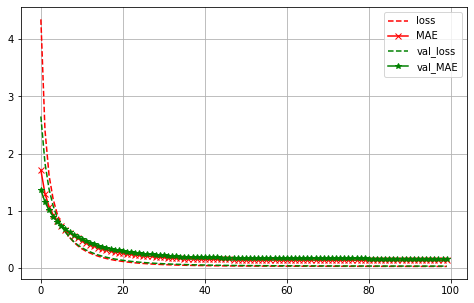

(0.49721647833833804, 0.20997788432165426)


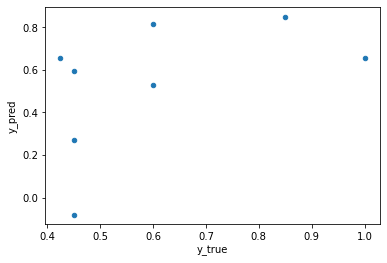

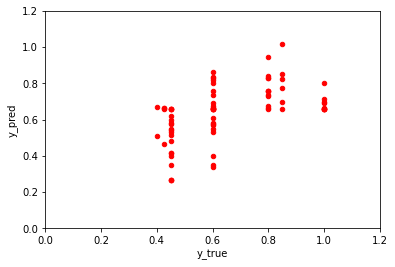

współczynnik R: 0.5


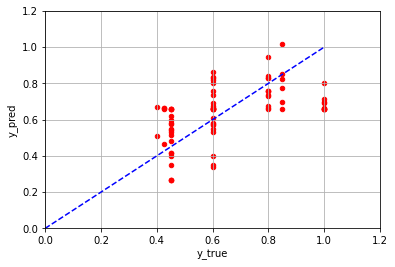

In [ ]:
plot_hist(history)
plot_sc(model1 = model)
plot_sc_all(model_ = model)
plot_sc_all2()

In [ ]:
'pandas DataFrame y_pred vs. y_true'

pd.DataFrame.from_dict({
    "y_pred": y_pred,
    "y_true": y_true
})

,y_pred,y_true
0,0.597318,0.450
1,0.657441,1.000
2,0.530301,0.600
3,-0.079615,0.450
4,0.657441,0.425
5,0.849725,0.850
6,0.817753,0.600
7,0.268702,0.450


In [ ]:
model.evaluate(
    X_test,
    y_test
)

1/1 [==============================] - 0s 21ms/step - loss: 0.0698 - MAE: 0.2151


[0.0698392391204834, 0.21511977910995483]

In [ ]:
#lista = []

In [ ]:
" pomoc naukowa"
y_pred_ = np.ravel(model.predict(scaler.transform(data_p))) 
y_true_ = np.ravel(CRFp) 
wynik = measures.pearsonr(y_pred_, y_true_)[0].round(2)
if wynik >0.9:
    lista.append(wynik)
print(wynik)
lista

0.12


NameError: name 'lista' is not defined

------------------
7. Zaprezentować rozwiązanie (vide - ocena modelu)
8. Przygotowć potok. Podzielić na katologi produkcyjne. Pokryć sieć testami jednostkowymi. 
------------------
class D_pre(tf.keras.layers.Layer):
    def __init__(self):
        super(D_pre,self).__init__()
    def call(self, inputs):
        return inputs * 2

#### ! OWN SCALER - keras.layers.layer

In [ ]:
class in_scaler_tf(tf.keras.layers.Layer):
    def __init__(self):
        super(in_scaler_tf,self).__init__()  #?ANNScaler,self
        
    def call(self, INPUT):
        "ANNScaler for PRE_4"
        x1 = tf.Variable([2,5.4,0,0,0,0,0,0,0,0.6,0,0])
        x2 = tf.Variable([0.0370370370370370,0.3125,2,2,4,2,0.066666667,0.04,0.010526316,3.47826087,2,0.434782609])
        x3 = tf.Variable([-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1], dtype = np.float32)
        return (INPUT-x1)*x2+x3

In [ ]:
class out_scaler_tf(tf.keras.layers.Layer):
    def __init__(self):
        super().__init__() #?out_scaler_tf,self
    def __call__(self,PREDICT):
        return (PREDICT + 1) / 3.33333333333333 + 0.4

In [ ]:
in_scaler_tf()([[5.0, 11.8, 0.0, 0.3, 0.0, 0.0, 18.0, 18.0, 0.0, 1.1, 0.0, 0.0]])

<tf.Tensor: shape=(1, 12), dtype=float32, numpy=
array([[-0.8888889 ,  1.        , -1.        , -0.39999998, -1.        ,
        -1.        ,  0.20000005, -0.28000003, -1.        ,  0.7391304 ,
        -1.        , -1.        ]], dtype=float32)>

In [ ]:
# required import scaler MinMax in_ = joblib.load('scalerMinMax.pkl')
in_ = joblib.load('scalerMinMax.pkl')
in_.transform([[
    5.0, 11.8, 0.0, 0.3, 0.0, 0.0, 18.0, 18.0, 0.0, 1.1, 0.0, 0.0
]])[0]

array([-0.88888889,  1.        , -1.        , -0.4       , -1.        ,
       -1.        ,  0.2       , -0.28      , -1.        ,  0.73913043,
       -1.        , -1.        ])

In [ ]:
assert np.allclose(
    in_scaler_tf(tf.Variable([
    5.0, 11.8, 0.0, 0.3, 0.0, 0.0, 18.0, 18.0, 0.0, 1.1, 0.0, 0.0
])).numpy()
    ,in_.transform([[
    5.0, 11.8, 0.0, 0.3, 0.0, 0.0, 18.0, 18.0, 0.0, 1.1, 0.0, 0.0
]])[0]
)

TypeError: __init__() takes 1 positional argument but 2 were given

9. **Uruchomić**, monitorować i utrzymać system./
------------------

In [ ]:
"""
import joblib

new_model = tf.keras.models.load_model('ANNmodel')
out_ = joblib.load('scaler2.pkl')
in_ = joblib.load('scalerMinMax.pkl')

data = pd.read_excel("SNN.xls",header = None, sheet_name= 1)
"""

'\nimport joblib\n\nnew_model = tf.keras.models.load_model(\'ANNmodel\')\nout_ = joblib.load(\'scaler2.pkl\')\nin_ = joblib.load(\'scalerMinMax.pkl\')\n\ndate = pd.read_excel("SNN.xls",header = None, sheet_name= 1)\n'

In [ ]:
# DOCKER 
# docker run -it --rm -v "C:\\Users\\Inspektor\\ANNmodel:/models/siecNN/1" -p 8500:8500 -p 8501:8501 -e MODEL_NAME=siecNN tensorflow/serving

In [ ]:
#SSN_CRFp(data_p[:10], in_, out_,new_model)  # 10 dodatkowych danych testowych
#in_.transform(data_p[:10])

# new_model.predict( ... )
# out_.inverse_transform( ...)

In [ ]:
# np.array(
#    in_.transform(data_p[:10])
#)
a = np.array([[-0.88888889,  1.        , -1.        , -0.4       , -1.        ,
        -1.        ,  0.2       , -0.28      , -1.        ,  0.73913043,
        -1.        , -1.        ],
       [-0.92592593,  0.3125    , -1.        , -0.4       ,  1.        ,
         0.        ,  1.        ,  0.2       , -1.        , -0.13043478,
        -1.        , -0.34782609],
       [-0.88888889,  0.21875   , -1.        , -1.        , -1.        ,
         0.2       , -0.46666667, -0.68      , -0.21052632,  0.2173913 ,
        -1.        , -1.        ],
       [-0.92592593,  0.03125   ,  1.        , -0.4       , -1.        ,
        -1.        , -1.        , -1.        , -1.        ,  0.46086957,
        -1.        ,  1.        ],
       [-0.92592593,  0.34375   , -1.        , -1.        ,  1.        ,
         1.        , -1.        , -1.        , -1.        , -0.51304348,
        -1.        , -0.13043478],
       [-0.88888889, -0.03125   , -1.        , -1.        ,  1.        ,
        -0.2       , -1.        ,  1.        , -1.        ,  0.56521739,
        -1.        ,  0.        ],
       [-0.85185185,  0.46875   ,  1.        , -1.        , -1.        ,
        -1.        , -1.        , -0.4       , -0.89473684,  0.73913043,
        -1.        , -1.        ],
       [-0.92592593,  0.46875   ,  1.        , -0.4       , -1.        ,
        -1.        , -1.        , -0.6       , -1.        ,  0.73913043,
         1.        ,  0.52173913],
       [-0.92592593, -0.71875   ,  0.        , -1.        ,  1.        ,
        -0.2       , -1.        ,  1.        , -1.        , -1.        ,
        -1.        ,  0.08695652],
       [-0.88888889,  0.15625   , -1.        , -0.4       ,  1.        ,
         0.2       ,  0.33333333, -0.2       , -0.68421053,  0.73913043,
        -1.        , -1.        ]])

In [ ]:
import json


request_json = json.dumps({
    "signature_name": "serving_default",
    "instances": a.tolist(),
})

In [ ]:
#siec NN
import requests

server_url = "http://localhost:8501/v1/models/siecNN:predict"
response = requests.post(server_url, data=request_json)
response.raise_for_status()  # raise an exception in case of error
response = response.json()

In [ ]:
# output scaler
out_.inverse_transform(
    response['predictions']
)

# assert _==_ 

## BRUDNOPIS

In [ ]:
from sklearn.pipeline import Pipeline

In [ ]:
pipe = Pipeline([
    ('scaler',StandardScaler()),('ssn',model)
])

In [ ]:
pipe.fit(X_train,y_train)

3/3 [==============================] - 0s 3ms/step - loss: 0.2507 - MAE: 0.3977


Pipeline(steps=[('scaler', StandardScaler()),
                ('ssn',
                 <keras.engine.sequential.Sequential object at 0x00000256E773D2E0>)])

BRAK scalera na wyjściu ! dodać output transform

In [ ]:
np.save("ha.npy", X_train.to_numpy()[0:3].reshape(-1,12,1))

In [ ]:
# bez normalizacji
!saved_model_cli run --dir ANNmodel --tag_set serve --signature_def serving_default --inputs {'flatten_input'}=ha.npy

Result for output key dense_1:
[[0.76234436]
 [0.78554124]
 [0.78554124]]


2022-06-10 22:10:39.358681: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'cudart64_110.dll'; dlerror: cudart64_110.dll not found
2022-06-10 22:10:39.358735: I tensorflow/stream_executor/cuda/cudart_stub.cc:29] Ignore above cudart dlerror if you do not have a GPU set up on your machine.
2022-06-10 22:10:52.723844: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'nvcuda.dll'; dlerror: nvcuda.dll not found
2022-06-10 22:10:52.723898: W tensorflow/stream_executor/cuda/cuda_driver.cc:269] failed call to cuInit: UNKNOWN ERROR (303)
2022-06-10 22:10:52.732035: I tensorflow/stream_executor/cuda/cuda_diagnostics.cc:169] retrieving CUDA diagnostic information for host: DESKTOP-RR620JF
2022-06-10 22:10:52.732241: I tensorflow/stream_executor/cuda/cuda_diagnostics.cc:176] hostname: DESKTOP-RR620JF
2022-06-10 22:10:52.733264: I tensorflow/core/platform/cpu_feature_guard.cc:151] This TensorFlow binary is

# ZAMIENIĆ NAZWY KOLUMN

In [ ]:
#odczytanie excela oraz konwersja z ',' na '.'
br_dane = pd.read_excel('SSN\ANN.xlsx', sheet_name = 'tabela', engine = 'openpyxl', thousands=".")

In [ ]:
br_dane.columns

Index(['Rodzaj skał stropowych', 'Wytrzymałość na rozciąganie',
       'Spękania pionowe', 'Zawodnienie', 'Płaszczyzny osłabienia',
       'Występowanie zaburzeń zalegania złoża ',
       'Średni postęp miesięczny frontu', 'Średni postęp mieś. likwidacji',
       'Występowanie zaszłości (stare wyrobiska, zroby)',
       'Głębokość zalegania złoża', 'Rzeczywista szerokość', 'Długość kotwi',
       'Dodatkowa obudowa', 'Czas istnienia wyrobiska',
       'Opadnięcia elementów SRS',
       'Rozwarstwienia stwierdzone badaniem endoskopowym', 'Predyspozycja',
       'Możliwość utrzymania'],
      dtype='object')

In [ ]:
{a:a.upper() for a in br_dane.columns}

{'Rodzaj skał stropowych': 'RODZAJ SKAŁ STROPOWYCH',
 'Wytrzymałość na rozciąganie': 'WYTRZYMAŁOŚĆ NA ROZCIĄGANIE',
 'Spękania pionowe': 'SPĘKANIA PIONOWE',
 'Zawodnienie': 'ZAWODNIENIE',
 'Płaszczyzny osłabienia': 'PŁASZCZYZNY OSŁABIENIA',
 'Występowanie zaburzeń zalegania złoża ': 'WYSTĘPOWANIE ZABURZEŃ ZALEGANIA ZŁOŻA ',
 'Średni postęp miesięczny frontu': 'ŚREDNI POSTĘP MIESIĘCZNY FRONTU',
 'Średni postęp mieś. likwidacji': 'ŚREDNI POSTĘP MIEŚ. LIKWIDACJI',
 'Występowanie zaszłości (stare wyrobiska, zroby)': 'WYSTĘPOWANIE ZASZŁOŚCI (STARE WYROBISKA, ZROBY)',
 'Głębokość zalegania złoża': 'GŁĘBOKOŚĆ ZALEGANIA ZŁOŻA',
 'Rzeczywista szerokość': 'RZECZYWISTA SZEROKOŚĆ',
 'Długość kotwi': 'DŁUGOŚĆ KOTWI',
 'Dodatkowa obudowa': 'DODATKOWA OBUDOWA',
 'Czas istnienia wyrobiska': 'CZAS ISTNIENIA WYROBISKA',
 'Opadnięcia elementów SRS': 'OPADNIĘCIA ELEMENTÓW SRS',
 'Rozwarstwienia stwierdzone badaniem endoskopowym': 'ROZWARSTWIENIA STWIERDZONE BADANIEM ENDOSKOPOWYM',
 'Predyspozycja': 'PREDY

In [ ]:
new_name = {'Rodzaj skał stropowych': 'TOP',
 'Wytrzymałość na rozciąganie': 'Rr',
 'Spękania pionowe': 'CRv',
 'Zawodnienie': 'HYDRO',
 'Płaszczyzny osłabienia': 'WEAK',
 'Występowanie zaburzeń zalegania złoża ': 'TECT',
 'Średni postęp miesięczny frontu': 'v_FR',
 'Średni postęp mieś. likwidacji': 'v_LI',
 'Występowanie zaszłości (stare wyrobiska, zroby)': 'ZROBY',
 'Głębokość zalegania złoża': 'H',
 'Rzeczywista szerokość': 'W',
 'Długość kotwi': 'L',
 'Dodatkowa obudowa': 'EXT',
 'Czas istnienia wyrobiska': 'T',
 'Opadnięcia elementów SRS': 'SRS',
 'Rozwarstwienia stwierdzone badaniem endoskopowym': 'ENDO',
 'Predyspozycja': 'CRFp',
 'Możliwość utrzymania': 'CRFm'}
new_name.values()

dict_values(['TOP', 'Rr', 'CRv', 'HYDRO', 'WEAK', 'TECT', 'v_FR', 'v_LI', 'ZROBY', 'H', 'W', 'L', 'EXT', 'T', 'SRS', 'ENDO', 'CRFp', 'CRFm'])

In [ ]:
# nowe nazwy
br_dane.columns = new_name.values()

In [ ]:
br_dane.head()

,TOP,Rr,CRv,HYDRO,WEAK,TECT,v_FR,v_LI,ZROBY,H,W,L,EXT,T,SRS,ENDO,CRFp,CRFm
0,5,11.8,0.0,0.3,0.0,0.0,18,18,0,1.10,17.5,1.8,0,3.5,0.0,0.0,1.0,1.0
1,4,9.6,0.0,0.3,0.5,0.5,30,30,0,0.85,12.0,1.6,2,6.0,0.0,1.5,1.0,1.0
2,56,9.3,0.0,0.0,0.0,0.6,8,8,75,0.95,11.6,1.8,5,1.0,0.0,0.0,1.0,1.0
3,4,8.7,1.0,0.3,0.0,0.0,0,0,0,1.02,10.0,2.6,3,4.0,0.0,4.6,1.0,1.0
4,4,9.7,0.0,0.0,0.5,1.0,0,0,0,0.74,7.0,1.8,0,6.0,0.0,2.0,1.0,1.0


In [ ]:
br_dane.to_csv('SSN\out1.csv', index = False)

In [ ]:
br_dane.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 80 entries, 0 to 79
Data columns (total 18 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   TOP     80 non-null     int64  
 1   Rr      80 non-null     float64
 2   CRv     80 non-null     float64
 3   HYDRO   80 non-null     float64
 4   WEAK    80 non-null     float64
 5   TECT    80 non-null     float64
 6   v_FR    80 non-null     int64  
 7   v_LI    80 non-null     int64  
 8   ZROBY   80 non-null     int64  
 9   H       80 non-null     float64
 10  W       80 non-null     float64
 11  L       80 non-null     float64
 12  EXT     80 non-null     int64  
 13  T       80 non-null     float64
 14  SRS     80 non-null     float64
 15  ENDO    80 non-null     float64
 16  CRFp    80 non-null     float64
 17  CRFm    80 non-null     float64
dtypes: float64(13), int64(5)
memory usage: 11.4 KB


GOTOWE - NAZWY KOLUMN ZAMIENIONE

# OKREŚLIĆ MARTWE WARTOŚCI (NIE UŻYTE)
1: 1,3,7 <br>
4: za dużo o 0,5

In [ ]:
[br_dane[a].unique() for a in br_dane]

[array([ 5,  4, 56,  6, 54,  2], dtype=int64),
 array([11.8 ,  9.6 ,  9.3 ,  8.7 ,  9.7 ,  8.5 , 10.1 ,  6.3 ,  9.1 ,
         9.4 ,  7.9 ,  8.9 ,  5.4 ,  8.72,  7.96,  9.5 , 10.  ,  9.  ,
         8.  ,  9.2 ,  8.6 ,  5.7 ,  7.1 ,  5.8 ,  5.5 ,  8.8 , 10.2 ,
         8.4 , 11.  , 10.3 , 10.7 ,  7.2 ,  9.31,  8.59, 10.8 ]),
 array([0. , 1. , 0.5]),
 array([0.3, 0. , 0.5, 0.6, 1. ]),
 array([0. , 0.5]),
 array([0. , 0.5, 0.6, 1. , 0.4]),
 array([18, 30,  8,  0, 20,  5, 15], dtype=int64),
 array([18, 30,  8,  0, 50, 15, 10, 20,  5], dtype=int64),
 array([  0,  75,  10,  30, 180, 150,  40, 160, 100,  60, 190, 105,  51,
         50,  80,  20,  70,  90,  63,  49,  77,  21, 130, 120,  64, 110,
         35], dtype=int64),
 array([1.1  , 0.85 , 0.95 , 1.02 , 0.74 , 1.05 , 0.6  , 1.14 , 1.175,
        1.11 , 1.15 ]),
 array([17.5, 12. , 11.6, 10. ,  7. ,  9. ,  8. , 11. ,  6.4,  7.5,  8.8,
         7.8,  6.5]),
 array([1.8, 1.6, 2.6]),
 array([ 0,  2,  5,  3, 45,  4,  1], dtype=int64),
 array([

In [ ]:
# need: from sklearn.preprocessing import OneHotEncoder
data[["TOP"]]

,TOP
0,5
1,4
2,56
3,4
4,4
...,...
75,4
76,4
77,4
78,4


In [ ]:
X = data[["TOP","Rr","CRv","HYDRO","WEAK","TECT","v_FR","v_LI","ZROBY","H",'W',"L","EXT","T","SRS","ENDO"]]
y = data[["CRFp","CRFm"]]

In [ ]:
y_pred, y_true

(array([0.5675193 , 0.48478448, 0.77284443, 0.5537507 , 0.591009  ,
        1.1018021 , 1.0581771 , 0.27189693, 0.7319187 , 0.46819705,
        0.23765223, 0.5769914 , 1.1723338 , 0.44224727, 0.25536656,
        0.61958617], dtype=float32),
 array([0.45 , 1.   , 0.6  , 0.45 , 0.425, 0.85 , 0.6  , 0.45 , 1.   ,
        0.6  , 0.8  , 0.45 , 0.6  , 0.45 , 0.45 , 0.45 ]))

In [ ]:
data[["TOP","Rr","CRv","HYDRO","WEAK","TECT","v_FR","v_LI","ZROBY","H","SRS","ENDO"]]

,TOP,Rr,CRv,HYDRO,WEAK,TECT,v_FR,v_LI,ZROBY,H,SRS,ENDO
0,5,11.80,0.0,0.3,0.0,0.0,18,18,0,1.10,0.0,0.0
1,4,9.60,0.0,0.3,0.5,0.5,30,30,0,0.85,0.0,1.5
2,56,9.30,0.0,0.0,0.0,0.6,8,8,75,0.95,0.0,0.0
3,4,8.70,1.0,0.3,0.0,0.0,0,0,0,1.02,0.0,4.6
4,4,9.70,0.0,0.0,0.5,1.0,0,0,0,0.74,0.0,2.0
...,...,...,...,...,...,...,...,...,...,...,...,...
75,4,8.59,0.0,0.0,0.0,0.0,15,15,35,1.11,0.0,0.5
76,4,8.59,0.0,0.0,0.0,0.0,15,15,35,1.11,0.0,0.3
77,4,8.59,1.0,0.0,0.0,0.0,15,15,21,1.11,0.0,0.0
78,4,10.80,1.0,0.0,0.0,0.0,15,15,21,1.11,0.0,0.5


In [ ]:
data[["TOP","Rr","CRv","HYDRO","WEAK","TECT","v_FR","v_LI","ZROBY","H",'W',"L","EXT","T","SRS","ENDO"]]

,TOP,Rr,CRv,HYDRO,WEAK,TECT,v_FR,v_LI,ZROBY,H,W,L,EXT,T,SRS,ENDO
0,5,11.80,0.0,0.3,0.0,0.0,18,18,0,1.10,17.5,1.8,0,3.5,0.0,0.0
1,4,9.60,0.0,0.3,0.5,0.5,30,30,0,0.85,12.0,1.6,2,6.0,0.0,1.5
2,56,9.30,0.0,0.0,0.0,0.6,8,8,75,0.95,11.6,1.8,5,1.0,0.0,0.0
3,4,8.70,1.0,0.3,0.0,0.0,0,0,0,1.02,10.0,2.6,3,4.0,0.0,4.6
4,4,9.70,0.0,0.0,0.5,1.0,0,0,0,0.74,7.0,1.8,0,6.0,0.0,2.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
75,4,8.59,0.0,0.0,0.0,0.0,15,15,35,1.11,7.0,1.8,0,2.0,0.0,0.5
76,4,8.59,0.0,0.0,0.0,0.0,15,15,35,1.11,7.0,1.8,0,3.0,0.0,0.3
77,4,8.59,1.0,0.0,0.0,0.0,15,15,21,1.11,7.0,1.8,0,3.0,0.0,0.0
78,4,10.80,1.0,0.0,0.0,0.0,15,15,21,1.11,7.0,1.8,0,3.0,0.0,0.5


# MODELE TF - SEKWENCYJNY, PODKLASOWY, FUNKCYJNY


#### SEKWENCYJNY - add

In [ ]:
model3 = keras.models.Sequential()
model3.add(keras.Input(shape=(12,)))
model3.add(keras.layers.Dense(5, activation = 'relu'))
model3.add(keras.layers.Dense(1))
model3.summary()

Model: "sequential_27"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_142 (Dense)            (None, 5)                 65        
_________________________________________________________________
dense_143 (Dense)            (None, 1)                 6         
Total params: 71
Trainable params: 71
Non-trainable params: 0
_________________________________________________________________


#### SEKWENCYJNY - LISTA

In [ ]:
model3 = keras.models.Sequential([
    keras.Input(shape=(12,)),
    keras.layers.Dense(5, activation = 'relu'),
    keras.layers.Dense(1)])

#### FUNKCYJNY

In [ ]:
input_ = keras.layers.Input(shape=(12,))
hidden1_ = keras.layers.Dense(8, activation = 'relu')(input_)
hidden2_ = keras.layers.Dense(4, activation = 'relu')(hidden1_)
output = keras.layers.Dense(1)(hidden2_)
model3 = keras.Model(inputs = [input_], outputs = [output])


# imperatywny styl programowania
#### PODKLASOWY

In [ ]:
class SSN1(keras.Model):
    def __init__(self, unit = 5, activation = 'relu', **kwargs):
        super().__init__(**kwargs)
        self.hidden1 = keras.layers.Dense(unit, activation = activation)
        self.hidden2 = keras.layers.Dense(unit, activation = activation)
        self.main_output = keras.layers.Dense(1)
        
    def call(self,inputs):
        hidden1 = self.hidden1(inputs)
        hidden2 = self.hidden2(hidden1)
        output = self.main_output(hidden2)
        return output
    
model4 = SSN1()

model4.compile(loss = 'mean_squared_error',
             optimizer = 'sgd',
             metrics = ["MAE"])

history4 = model4.fit(X_train, y_train, epochs = 20)

Epoch 1/20
3/3 [==============================] - 0s 2ms/step - loss: 0.6362 - MAE: 0.6285
Epoch 2/20
3/3 [==============================] - 0s 997us/step - loss: 0.5141 - MAE: 0.5855
Epoch 3/20
3/3 [==============================] - 0s 998us/step - loss: 0.4270 - MAE: 0.5445
Epoch 4/20
3/3 [==============================] - 0s 2ms/step - loss: 0.3831 - MAE: 0.5165
Epoch 5/20
3/3 [==============================] - 0s 2ms/step - loss: 0.3419 - MAE: 0.4894
Epoch 6/20
3/3 [==============================] - 0s 2ms/step - loss: 0.3114 - MAE: 0.4665
Epoch 7/20
3/3 [==============================] - 0s 1ms/step - loss: 0.2834 - MAE: 0.4465
Epoch 8/20
3/3 [==============================] - 0s 998us/step - loss: 0.2584 - MAE: 0.4252
Epoch 9/20
3/3 [==============================] - 0s 2ms/step - loss: 0.2397 - MAE: 0.4087
Epoch 10/20
3/3 [==============================] - 0s 997us/step - loss: 0.2241 - MAE: 0.3951
Epoch 11/20
3/3 [==============================] - 0s 1ms/step - loss: 0.2109 - M

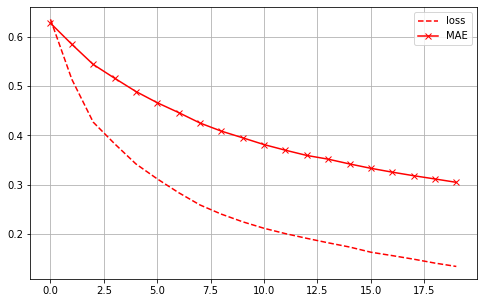

(-0.5562875688014095, 0.15216697039131633)


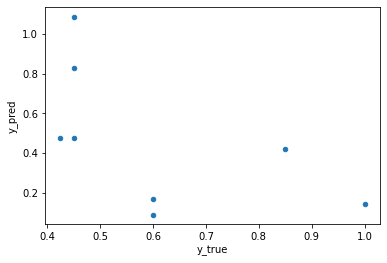

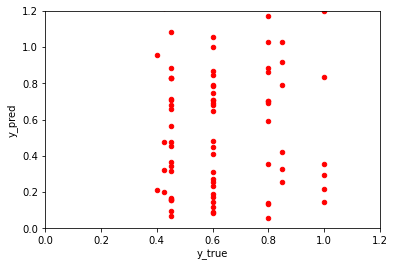

współczynnik R: 0.26


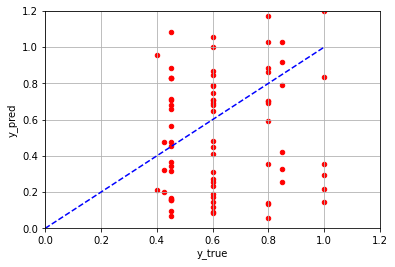

In [ ]:
plot_hist(history4)
plot_sc(model1 = model4)
plot_sc_all(model_ = model4)
plot_sc_all2(model4)

In [ ]:
model3.compile(loss = 'mean_squared_error',
             optimizer = 'sgd',
             metrics = ["MAE"])

In [ ]:
"""model3.compile(loss = 'mean_squared_error',
             optimizer = keras.optimizers.SGD(lr = 1e-3),
             metrics = ["MAE"])"""

'model3.compile(loss = \'mean_squared_error\',\n             optimizer = keras.optimizers.SGD(lr = 1e-3),\n             metrics = ["MAE"])'

In [ ]:
history3 = model3.fit(X_train, y_train, epochs = 500,
                    validation_split = 0.2, shuffle = True)

Epoch 1/500
2/2 [==============================] - 0s 47ms/step - loss: 0.4941 - MAE: 0.6012 - val_loss: 0.3512 - val_MAE: 0.4604
Epoch 2/500
2/2 [==============================] - 0s 8ms/step - loss: 0.4387 - MAE: 0.5680 - val_loss: 0.3391 - val_MAE: 0.4428
Epoch 3/500
2/2 [==============================] - 0s 8ms/step - loss: 0.3986 - MAE: 0.5430 - val_loss: 0.3304 - val_MAE: 0.4288
Epoch 4/500
2/2 [==============================] - 0s 8ms/step - loss: 0.3611 - MAE: 0.5155 - val_loss: 0.3217 - val_MAE: 0.4147
Epoch 5/500
2/2 [==============================] - 0s 8ms/step - loss: 0.3286 - MAE: 0.4935 - val_loss: 0.3141 - val_MAE: 0.4017
Epoch 6/500
2/2 [==============================] - 0s 8ms/step - loss: 0.3013 - MAE: 0.4722 - val_loss: 0.3065 - val_MAE: 0.3898
Epoch 7/500
2/2 [==============================] - 0s 8ms/step - loss: 0.2773 - MAE: 0.4524 - val_loss: 0.3001 - val_MAE: 0.3786
Epoch 8/500
2/2 [==============================] - 0s 8ms/step - loss: 0.2579 - MAE: 0.4348 - va

2/2 [==============================] - 0s 8ms/step - loss: 0.0481 - MAE: 0.1719 - val_loss: 0.1808 - val_MAE: 0.3053
Epoch 65/500
2/2 [==============================] - 0s 8ms/step - loss: 0.0475 - MAE: 0.1710 - val_loss: 0.1798 - val_MAE: 0.3047
Epoch 66/500
2/2 [==============================] - 0s 7ms/step - loss: 0.0472 - MAE: 0.1701 - val_loss: 0.1792 - val_MAE: 0.3052
Epoch 67/500
2/2 [==============================] - 0s 7ms/step - loss: 0.0465 - MAE: 0.1689 - val_loss: 0.1784 - val_MAE: 0.3052
Epoch 68/500
2/2 [==============================] - 0s 7ms/step - loss: 0.0462 - MAE: 0.1684 - val_loss: 0.1779 - val_MAE: 0.3058
Epoch 69/500
2/2 [==============================] - 0s 7ms/step - loss: 0.0456 - MAE: 0.1670 - val_loss: 0.1770 - val_MAE: 0.3054
Epoch 70/500
2/2 [==============================] - 0s 7ms/step - loss: 0.0452 - MAE: 0.1662 - val_loss: 0.1764 - val_MAE: 0.3055
Epoch 71/500
2/2 [==============================] - 0s 7ms/step - loss: 0.0447 - MAE: 0.1653 - val_loss

Epoch 127/500
2/2 [==============================] - 0s 7ms/step - loss: 0.0306 - MAE: 0.1310 - val_loss: 0.1453 - val_MAE: 0.2860
Epoch 128/500
2/2 [==============================] - 0s 7ms/step - loss: 0.0305 - MAE: 0.1305 - val_loss: 0.1449 - val_MAE: 0.2855
Epoch 129/500
2/2 [==============================] - 0s 7ms/step - loss: 0.0303 - MAE: 0.1301 - val_loss: 0.1446 - val_MAE: 0.2853
Epoch 130/500
2/2 [==============================] - 0s 7ms/step - loss: 0.0302 - MAE: 0.1297 - val_loss: 0.1441 - val_MAE: 0.2847
Epoch 131/500
2/2 [==============================] - 0s 7ms/step - loss: 0.0300 - MAE: 0.1293 - val_loss: 0.1436 - val_MAE: 0.2842
Epoch 132/500
2/2 [==============================] - 0s 7ms/step - loss: 0.0299 - MAE: 0.1292 - val_loss: 0.1433 - val_MAE: 0.2841
Epoch 133/500
2/2 [==============================] - 0s 6ms/step - loss: 0.0298 - MAE: 0.1287 - val_loss: 0.1427 - val_MAE: 0.2832
Epoch 134/500
2/2 [==============================] - 0s 6ms/step - loss: 0.0296 - M

2/2 [==============================] - 0s 7ms/step - loss: 0.0209 - MAE: 0.1034 - val_loss: 0.1155 - val_MAE: 0.2520
Epoch 252/500
2/2 [==============================] - 0s 7ms/step - loss: 0.0209 - MAE: 0.1033 - val_loss: 0.1153 - val_MAE: 0.2517
Epoch 253/500
2/2 [==============================] - 0s 7ms/step - loss: 0.0210 - MAE: 0.1035 - val_loss: 0.1149 - val_MAE: 0.2509
Epoch 254/500
2/2 [==============================] - 0s 7ms/step - loss: 0.0208 - MAE: 0.1033 - val_loss: 0.1149 - val_MAE: 0.2510
Epoch 255/500
2/2 [==============================] - 0s 7ms/step - loss: 0.0208 - MAE: 0.1030 - val_loss: 0.1148 - val_MAE: 0.2508
Epoch 256/500
2/2 [==============================] - 0s 7ms/step - loss: 0.0207 - MAE: 0.1029 - val_loss: 0.1146 - val_MAE: 0.2504
Epoch 257/500
2/2 [==============================] - 0s 7ms/step - loss: 0.0207 - MAE: 0.1029 - val_loss: 0.1144 - val_MAE: 0.2503
Epoch 258/500
2/2 [==============================] - 0s 7ms/step - loss: 0.0207 - MAE: 0.1028 - v

2/2 [==============================] - 0s 7ms/step - loss: 0.0171 - MAE: 0.0930 - val_loss: 0.1029 - val_MAE: 0.2333
Epoch 376/500
2/2 [==============================] - 0s 7ms/step - loss: 0.0171 - MAE: 0.0929 - val_loss: 0.1028 - val_MAE: 0.2329
Epoch 377/500
2/2 [==============================] - 0s 7ms/step - loss: 0.0170 - MAE: 0.0930 - val_loss: 0.1027 - val_MAE: 0.2327
Epoch 378/500
2/2 [==============================] - 0s 7ms/step - loss: 0.0170 - MAE: 0.0929 - val_loss: 0.1027 - val_MAE: 0.2329
Epoch 379/500
2/2 [==============================] - 0s 7ms/step - loss: 0.0170 - MAE: 0.0930 - val_loss: 0.1027 - val_MAE: 0.2330
Epoch 380/500
2/2 [==============================] - 0s 7ms/step - loss: 0.0170 - MAE: 0.0929 - val_loss: 0.1026 - val_MAE: 0.2329
Epoch 381/500
2/2 [==============================] - 0s 6ms/step - loss: 0.0169 - MAE: 0.0926 - val_loss: 0.1025 - val_MAE: 0.2328
Epoch 382/500
2/2 [==============================] - 0s 7ms/step - loss: 0.0169 - MAE: 0.0927 - v

2/2 [==============================] - 0s 7ms/step - loss: 0.0149 - MAE: 0.0887 - val_loss: 0.0953 - val_MAE: 0.2193
Epoch 500/500
2/2 [==============================] - 0s 7ms/step - loss: 0.0149 - MAE: 0.0887 - val_loss: 0.0952 - val_MAE: 0.2190


## DO EXCELA -_- i brudnopis

In [ ]:
"DO EXCELA"
pd.DataFrame.from_dict({"y_pred": y_pred,
"y_true": y_true}).to_excel("outputa.xlsx")

In [ ]:
hidden1_ = keras.layers.Dense(8, activation = 'relu')(input_)
hidden2_ = keras.layers.Dense(4, activation = 'relu')(hidden1_)
współczynnik R: 0.73
loss: 0.0177 - MAE: 0.0967 - val_loss: 0.0189 - val_MAE: 0.1220 

współczynnik R: 0.69
loss: 0.0102 - MAE: 0.0732

współczynnik R: 0.76
loss: 0.0132 - MAE: 0.0836 - val_loss: 0.0153 - val_MAE: 0.1080
                
współczynnik R: 0.8
loss: 0.0120 - MAE: 0.0870 + dane bez 54 i 56

In [ ]:
history3.history.keys()

dict_keys(['loss', 'MAE', 'val_loss', 'val_MAE'])

In [ ]:
X_train

array([[-9.35684378e-01,  6.68472755e-01, -1.04257207e+00,
        -5.71428571e-01,  1.44115338e+00,  2.86909095e+00,
        -1.40647737e+00, -1.34044852e+00, -1.30812470e+00,
        -4.40769288e+00, -9.94405766e-01,  9.05922566e-01],
       [ 1.69079809e+00, -5.78742543e-01,  6.95048047e-02,
         5.00000000e-01,  1.44115338e+00, -5.77264545e-01,
        -1.40647737e+00, -1.34044852e+00, -4.74924253e-01,
         3.74343810e-01,  4.36393897e-01, -2.88438101e-01],
       [ 3.77556854e-01, -5.09452804e-01,  1.18158168e+00,
        -5.71428571e-01,  1.44115338e+00, -5.77264545e-01,
         1.03691437e+00,  7.09950744e-01, -1.30812470e+00,
         4.93894727e-01, -2.79005934e-01,  1.41531739e-01],
       [-9.35684378e-01,  8.76341971e-01,  6.95048047e-02,
        -5.71428571e-01, -6.93888666e-01, -5.77264545e-01,
         1.03691437e+00,  7.09950744e-01, -4.74924253e-01,
         4.93894727e-01,  1.86719356e+00,  4.28178299e-01],
       [ 3.77556854e-01, -1.06377071e+00, -1.0425720

In [ ]:
history.__dict__

{'validation_data': None,
 'model': <tensorflow.python.keras.engine.sequential.Sequential at 0x25779b3c220>,
 '_chief_worker_only': None,
 '_supports_tf_logs': False,
 'history': {'loss': [0.7174222469329834,
   0.5683904886245728,
   0.45610177516937256,
   0.3672577738761902,
   0.2973271310329437,
   0.24375903606414795,
   0.20533277094364166,
   0.17284613847732544,
   0.14804472029209137,
   0.1289183497428894,
   0.11476979404687881,
   0.10341423004865646,
   0.093894824385643,
   0.08619829267263412,
   0.0807400494813919,
   0.07601331174373627,
   0.07136454433202744,
   0.06785756349563599,
   0.06529957056045532,
   0.06321681290864944,
   0.06113122031092644,
   0.059588365256786346,
   0.05785553157329559,
   0.05652310699224472,
   0.055016931146383286,
   0.05374247208237648,
   0.05260297283530235,
   0.05170762538909912,
   0.05052926391363144,
   0.049678049981594086,
   0.048931680619716644,
   0.048271581530570984,
   0.047457318753004074,
   0.04660976305603981,


In [ ]:
history.params

{'verbose': 1, 'epochs': 20, 'steps': 32}

In [ ]:
# tf.keras.utils.plot_model(model, "my_ssn.png", show_shapes=True)

## NORMALIZATION LAYER

In [ ]:
X_train, X_test, y_train, y_test

In [ ]:
norm_layer = tf.keras.layers.Normalization(input_shape=X_train.shape[1:])

In [ ]:
norm_layer.adapt(X_train.to_numpy())

In [ ]:
norm_layer(X_train)

<tf.Tensor: shape=(72, 12), dtype=float32, numpy=
array([[-1.0482652 ,  0.73076844, -1.114172  , -0.5686104 ,  1.371131  ,
         2.7116847 , -1.4023348 , -1.3352537 , -1.31131   , -4.180825  ,
        -1.0199231 ,  0.87262726],
       [ 1.9115418 , -0.55409974,  0.        ,  0.4634892 ,  1.371131  ,
        -0.620078  , -1.4023348 , -1.3352537 , -0.44868487,  0.37921032,
         0.36825195, -0.3218434 ],
       [ 0.43163827, -0.48271823,  1.114172  , -0.5686104 ,  1.371131  ,
        -0.620078  ,  1.0365083 ,  0.68233854, -1.31131   ,  0.4932111 ,
        -0.3258356 ,  0.10816609],
       [-1.0482652 ,  0.94491327,  0.        , -0.5686104 , -0.72932494,
        -0.620078  ,  1.0365083 ,  0.68233854, -0.44868487,  0.4932111 ,
         1.756427  ,  0.39483902],
       [ 0.43163827, -1.053771  , -1.114172  , -0.5686104 ,  1.371131  ,
         1.0458033 , -0.79262406, -0.83085567,  1.0609093 ,  0.03720796,
         1.756427  , -1.0385258 ],
       [-1.0482652 ,  0.23109753, -1.114172  

In [ ]:
def huber_fn(y_true, y_pred):
    error = y_true - y_pred
    is_small_error = tf.abs(error) < 1
    squared_loss = tf.square(error) /2 
    linear_loss = tf.abs(error) - 0.5
    return tf.where(is_small_error, squared_loss, linear_loss)

In [ ]:
model4 = keras.models.Sequential([
    norm_layer,
    keras.layers.Dense(5, activation = 'relu'),
    keras.layers.Dense(1)])

model4.compile(loss = 'mean_squared_error',
             optimizer = 'sgd',
             metrics = ["MAE"])

history4 = model4.fit(X_train.to_numpy(), y_train.to_numpy(), epochs = 40,
                    validation_split = 0.2, shuffle = True)

Epoch 1/40
2/2 [==============================] - 1s 327ms/step - loss: 2.0508 - MAE: 1.3195 - val_loss: 1.7182 - val_MAE: 1.1977
Epoch 2/40
2/2 [==============================] - 0s 53ms/step - loss: 1.5957 - MAE: 1.1530 - val_loss: 1.3713 - val_MAE: 1.0490
Epoch 3/40
2/2 [==============================] - 0s 58ms/step - loss: 1.2688 - MAE: 1.0159 - val_loss: 1.1226 - val_MAE: 0.9386
Epoch 4/40
2/2 [==============================] - 0s 57ms/step - loss: 1.0263 - MAE: 0.9074 - val_loss: 0.9328 - val_MAE: 0.8481
Epoch 5/40
2/2 [==============================] - 0s 59ms/step - loss: 0.8475 - MAE: 0.8135 - val_loss: 0.7916 - val_MAE: 0.7719
Epoch 6/40
2/2 [==============================] - 0s 66ms/step - loss: 0.7096 - MAE: 0.7357 - val_loss: 0.6819 - val_MAE: 0.7058
Epoch 7/40
2/2 [==============================] - 0s 63ms/step - loss: 0.6007 - MAE: 0.6695 - val_loss: 0.5951 - val_MAE: 0.6476
Epoch 8/40
2/2 [==============================] - 0s 56ms/step - loss: 0.5150 - MAE: 0.6148 - va

In [ ]:
# need from datetime import datetime

now = datetime.now()
urrent_time = now.strftime("%H_%M_%S")
urrent_time

'17_54_42'

In [ ]:
lista = []
plt.figure(figsize=(8, 3.5))
for _ in range(3):
    model = keras.models.Sequential()
    model.add(keras.layers.Dense(4, activation = 'relu', input_shape = (12,)))
    model.add(keras.layers.Dense(4, activation = 'relu'))
    model.add(keras.layers.Dense(1))
    optimizer = keras.optimizers.Adam(lr = 0.01, beta_1=0.9, beta_2 = 0.999)
    model.compile(loss = huber_fn,
                 optimizer = optimizer,
                 metrics = ["MAE"])
    history = model.fit(X_train, y_train, epochs = 10,
                        validation_split = 0.2, shuffle = True, verbose=0)
    # pomoc naukowa
    y_pred_ = np.ravel(model.predict(scaler.transform(data_p))) 
    y_true_ = np.ravel(CRFp) 
    wynik = measures.pearsonr(y_pred_, y_true_)[0].round(2)
    lista.append(wynik)
    plt.plot(history.history['loss'])
    #plt.plot(history.history['val_loss'], '--')
print(lista, 'średnia: ', np.mean(lista).round(3), 'max: ', np.max(lista).round(3), 'struktura: ', struc(model))

now = datetime.now()
urrent_time = now.strftime("%H_%M_%S")

plt.text(0,0.05, s = "średnia: {}  max: {}  struktura: {}".format(np.mean(lista).round(3),np.max(lista).round(3),struc(model)) )
plt.savefig('{}'.format(urrent_time))

C:\Users\Inspektor\anaconda3\lib\site-packages\keras\optimizer_v2\adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


NameError: name 'huber_fn' is not defined

<Figure size 576x252 with 0 Axes>

In [ ]:
aa = 'hahah'

In [ ]:
'{aa}'

'{aa}'

In [ ]:
#golas
np.mean(lista).round(3)

0.301

In [ ]:
lista # kernel_initializer = 'he_normal'

[0.07, 0.46, 0.39, 0.23, 0.46, 0.3, 0.18, 0.35, 0.05, 0.21]

In [ ]:
lista #selu + lecun_normal

[0.28, 0.18, 0.7, -0.26, 0.6, 0.46, 0.29]

In [ ]:
lista #selu + lecun_normal

[0.72, 0.56, 0.56, 0.55, 0.35, 0.37, 0.16]

In [ ]:
lista # obcinanie gradientów

[0.12, 0.45, 0.34, 0.56, 0.54, 0.25, 0.64]

In [ ]:
lista #optimizer = keras.optimizers.SGD(lr=0.001, momentum = 0.9)

[0.49, 0.27, 0.38, -0.03, 0.44, 0.17, 0.16]

In [ ]:
lista

[0.22, -0.15, 0.33, -0.08, 0.44, 0.38, 0.61]

In [ ]:
lista

[0.2, 0.23, 0.09, 0.12, 0.47, -0.2, 0.07]

In [ ]:
lista # optimizers.SGD(lr=0.01, momentum = 0.9, nesterov = True)

[0.67, 0.6, 0.64, 0.62, 0.37, 0.72, 0.6]

In [ ]:
lista #momentum = 0.9, nesterov = True)

[0.46, 0.16, 0.43, 0.68, 0.45, 0.65, 0.33]

In [ ]:
lista #keras.optimizers.RMSprop(lr = 0.01, rho = 0.9)

[0.78, 0.78, 0.43, 0.74, 0.89, 0.79, 0.78]

In [ ]:
lista # keras.optimizers.Adam(lr = 0.01, beta_1=0.9, beta_2 = 0.999)

[0.92, 0.76, 0.69, 0.89, -0.13, 0.68, 0.83]

In [ ]:
"""    optimizer = keras.optimizers.Adam(lr = 0.01, beta_1=0.9, beta_2 = 0.999)
    model.compile(loss = huber_fn,"""
[0.82, 0.78, 0.83, 0.69, 0.76, 0.72, 0.81] 0.773

In [ ]:
    optimizer = keras.optimizers.Adam(lr = 0.01, beta_1=0.9, beta_2 = 0.999)
    model.compile(loss = huber_fn,
                 optimizer = optimizer,
                 metrics = ["MAE"])
    history = model.fit(X_train, y_train, epochs = 50,
                        validation_split = 0.2, shuffle = True, verbose=0)

[0.8, 0.69, 0.72, 0.78, 0.68, 0.87, 0.72, 0.77, 0.72, 0.62] 0.737 [6, 5, 1]
[0.48, 0.67, 0.71, 0.68, 0.7, 0.48, 0.49, 0.8, 0.6, 0.85] średnia:  0.646 max:  0.85 struktura:  [6, 5, 1]
[0.74, 0.68, 0.83, 0.74, 0.77, 0.79, 0.74, 0.75, 0.83, 0.77] średnia:  0.764 max:  0.83 struktura:  [6, 5, 1]

Text(0.5, 1.0, 'Huber loss')

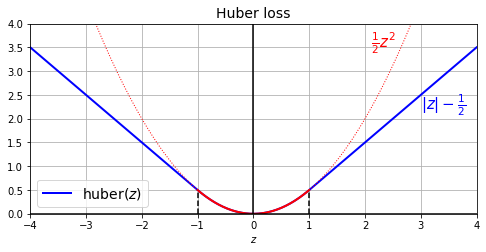

In [ ]:
plt.figure(figsize=(8, 3.5))
z = np.linspace(-4, 4, 200)
z_center = np.linspace(-1, 1, 200)
plt.plot(z, huber_fn(0, z), "b-", linewidth=2, label="huber($z$)")
plt.plot(z, z ** 2 / 2, "r:", linewidth=1)
plt.plot(z_center, z_center ** 2 / 2, "r", linewidth=2)
plt.plot([-1, -1], [0, huber_fn(0., -1.)], "k--")
plt.plot([1, 1], [0, huber_fn(0., 1.)], "k--")
plt.gca().axhline(y=0, color='k')
plt.gca().axvline(x=0, color='k')
plt.text(2.1, 3.5, r"$\frac{1}{2}z^2$", color="r", fontsize=15)
plt.text(3.0, 2.2, r"$|z| - \frac{1}{2}$", color="b", fontsize=15)
plt.axis([-4, 4, 0, 4])
plt.grid(True)
plt.xlabel("$z$")
plt.legend(fontsize=14)
plt.title("Huber loss", fontsize=14)

# wykres pudełkowy

DODAĆ OPIS WYKRESU PUDEŁKOWEGO

In [ ]:
list(zip(
    np.array(ttt).max(axis=-1).round(decimals=2),
    zzz))

[(0.57, '[6, 6, 1]'),
 (0.51, '[6, 6, 1]'),
 (0.61, '[6, 6, 1]'),
 (0.54, '[7, 7, 1]'),
 (0.71, '[7, 7, 1]'),
 (0.61, '[7, 7, 1]'),
 (0.79, '[8, 8, 1]'),
 (0.61, '[8, 8, 1]'),
 (0.72, '[8, 8, 1]'),
 (0.67, '[9, 9, 1]')]

(array([0, 1, 2, 3, 4, 5, 6, 7, 8, 9]),
 [Text(0, 0, '[6, 6, 1]'),
  Text(1, 0, '[6, 6, 1]'),
  Text(2, 0, '[6, 6, 1]'),
  Text(3, 0, '[7, 7, 1]'),
  Text(4, 0, '[7, 7, 1]'),
  Text(5, 0, '[7, 7, 1]'),
  Text(6, 0, '[8, 8, 1]'),
  Text(7, 0, '[8, 8, 1]'),
  Text(8, 0, '[8, 8, 1]'),
  Text(9, 0, '[9, 9, 1]')])

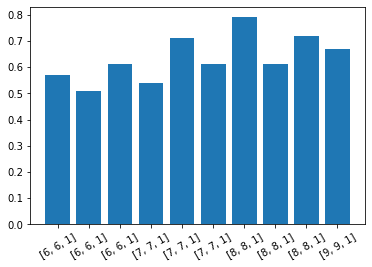

In [ ]:
plt.bar(x = range(10), height = np.array(ttt).max(axis=-1).round(decimals=2), tick_label = zzz)
plt.xticks(rotation=30)

In [ ]:
np.array(
    [0.5153855714258468, 0.5707966084694087, 0.2100915948397551, 0.1306612508102959, 0.14141928875696913, 0.03212405690508556, 0.38144689542535815, 0.3134357475824918, -0.17324073809702217, 0.3144764945250589, 0.3625491499304446, 0.5154834016586525, 0.3714525932746603, 0.24359036973111753, 0.033204918720414034, 0.41054674449739464, -0.29050180737630893, 0.2930661364043673, 0.38557142684767987, 0.20750257754766294]
)

array([ 0.51538557,  0.57079661,  0.21009159,  0.13066125,  0.14141929,
        0.03212406,  0.3814469 ,  0.31343575, -0.17324074,  0.31447649,
        0.36254915,  0.5154834 ,  0.37145259,  0.24359037,  0.03320492,
        0.41054674, -0.29050181,  0.29306614,  0.38557143,  0.20750258])

In [ ]:
aa = [0.21401663718278804, 0.017082113657570758, 0.2978165770673664, 0.018209558008284693, 0.2605125372180794, 0.29988282278829326, 0.5475986079200728, 0.2199903349631622, 0.20368079793471622, 0.6485132866454129]
bb = [0.5403418501610305, 0.38966533614443516, 0.2898488882769027, 0.23441261054000367, 0.10731107801696596, 0.4650648287759591, 0.2832627965458995, 0.3789046322678345, 0.34481460631074756, 0.32518642005530835]

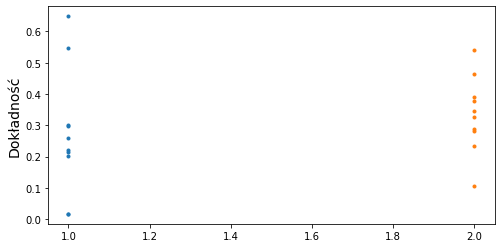

In [ ]:
plt.figure(figsize=(8, 4))
plt.plot([1]*10, aa, ".")
plt.plot([2]*10, bb, ".")
#plt.boxplot([aa,bb])
plt.ylabel("Dokładność", fontsize=14)
plt.show()

# seaborn

In [ ]:
# need: import seaborn as sns
sns.set_theme(style="darkgrid")

y_pred_ = np.ravel(model.predict(scaler.transform(data_p))) 
y_true_ = np.ravel(CRFp)

In [ ]:
pal = dict(male="#6495ED", female="#F08080")

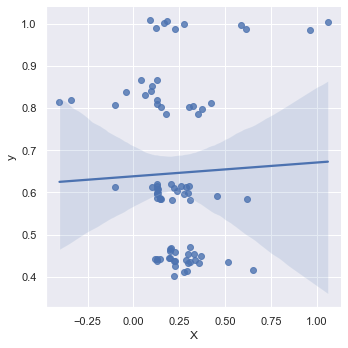

In [ ]:
df_ = pd.DataFrame(dict(X=y_pred_, y=y_true_))
g = sns.lmplot(x="X", y="y", data = df_, palette=pal, y_jitter=.02, logistic=False, truncate=True)
#g.set(xlim=(0, 80), ylim=(-.05, 1.05))

In [ ]:
lern = {
    'neur' : [2,3,4],
    'opt' : ['AAA','BBB','CCC']
}


In [ ]:
di = {}
lern = {
    'neur' : [2,3,4]
}
for change in [3,4,5]:
    di[str(change) + '_neurons'] = []
    
    for _ in range(2):
        
        model = keras.models.Sequential()
        model.add(keras.layers.Dense(change, activation = 'relu', input_shape = (12,), kernel_initializer = 'he_normal'))
        model.add(keras.layers.Dense(1))
        
        model.compile(loss = 'mean_squared_error',
                     optimizer = 'SGD',
                     metrics = ["MAE"])
        
        history = model.fit(X_train, y_train, epochs = 15,
                            validation_split = 0.2, shuffle = True,verbose=0)
        
        y_pred_ = np.ravel(model.predict(scaler.transform(data_p))) 
        y_true_ = np.ravel(CRFp) 
        wynik = measures.pearsonr(y_pred_, y_true_)[0]
        
        di[str(change) + '_neurons'].append(wynik)

In [ ]:
#di
pd.DataFrame.from_dict(di)

,3_neurons,4_neurons,5_neurons
0,0.014137,0.017338,0.289532
1,0.160499,-0.174540,0.244994


# GOTOWA SIEĆ 2018

In [ ]:
import joblib

new_model = tf.keras.models.load_model('ANNmodel')
out_ = joblib.load('scaler2.pkl')
in_ = joblib.load('scalerMinMax.pkl')

date = pd.read_excel("SNN.xls",header = None, sheet_name= 1)


def SSN_CRFp(date, input_scaler, output_scaler, model, flatten = True):
    predict_ = output_scaler.inverse_transform(model.predict(input_scaler.transform(date))).round(5)
    if flatten:
        return predict_.flatten()
    else:
        return predict_   

    
SSN_CRFp(data_p, in_, out_,new_model)

NameError: name 'date_p' is not defined

In [ ]:
in_ = joblib.load('scalerMinMax.pkl')

# EXTRA TOOL'S

#### #_1 KEEP OUTPUTS IN PANDAS AND PICKLE

In [ ]:
import pickle

class hold_data:
    """
    add_out:
    print_:
    save_to_file:
    """
    def __init__(self):
        self.list_: list = []

    def add_out(self, NET,MAX_MSE,TUNER_KERAS,OTHER, EXTRAS1, EXTRAS2) -> list:
        """
        'NET','MAX_MSE','TUNER_KERAS','OTHER', 'EXTRAS#1','EXTRAS#2'
        """
        self.list_.append([NET,MAX_MSE,TUNER_KERAS,OTHER, EXTRAS1, EXTRAS2])
        print('Added: ',
            [NET,MAX_MSE,TUNER_KERAS,OTHER, EXTRAS1, EXTRAS2]
            )
    
    def _make_pd(self) -> None:
        self.pd_ = pd.DataFrame(self.list_, columns = ['NET','MAX_MSE','TUNER_KERAS','OTHER', 'EXTRAS#1','EXTRAS#2'])
        return self.pd_

    def print_(self) -> None:
        print(self._make_pd())
        
    def save_to_file(self, name: str):
        self._make_pd().to_excel(f'{name}.xlsx')
        with open(f'{name}.pickle', 'wb') as f:
            pickle.dump(self.list_, f)

In [ ]:
list_output = hold_data()

In [ ]:
list_output.add_out(*['net1',0.5,None,'txt',None,'Test'])

Added:  ['net1', 0.5, None, 'txt', None, 'Test']


In [ ]:
list_output.print_()

    NET  MAX_MSE TUNER_KERAS OTHER EXTRAS#1 EXTRAS#2
0  net1      0.5        None   txt     None     Test


In [ ]:
list_output.save_to_file('test')

INFO:tensorflow:Assets written to: ram://83ad7620-b0c3-4e36-8eb2-899cdf966e14/assets


In [ ]:
?
list_output.add_out(*[            #keeps model outputs #_1 FIRST STEP - list_output.add_out(...)
    model.name,
    model.evaluate(X_test,y_test)[0],
    'no KT',
    'basic',
    None,
    None])

In [ ]:
# open pickle
with open('test.pickle', 'rb') as f:
    print(pickle.load(f))

FileNotFoundError: Unsuccessful TensorSliceReader constructor: Failed to find any matching files for ram://424c5292-c4d7-403c-9dac-c83de8a4a195/variables/variables
 You may be trying to load on a different device from the computational device. Consider setting the `experimental_io_device` option in `tf.saved_model.LoadOptions` to the io_device such as '/job:localhost'.

#### #_2 

In [ ]:
# TRAIN SUBCLASS MODEL TO CHECK MEAN AND MAX r VALUE

In [ ]:
def net1_(NEURONS: int) -> tf.keras.Model:
    model = keras.models.Sequential()
    model.add(keras.layers.Dense(NEURONS, activation = 'relu', input_shape = (12,)))
    model.add(keras.layers.Dense(NEURONS, activation = 'relu'))
    model.add(keras.layers.Dense(1))
    optimizer = keras.optimizers.Adam(learning_rate = 0.01, beta_1=0.9, beta_2 = 0.999)
    model.compile(loss = "MSE",
                 optimizer = optimizer,
                 metrics = ["MAE"])
    return model

                    
class plot_train_via_neurons:
    def __init__(self, NET:tf.keras.Model, scaler, full_ds: tuple):
        assert isinstance(NET(1), tf.keras.Model), "No keras model"      #added 1 to NET in oder to check return by fun type
        self.net_ = NET
        self.input_scaler = scaler
        self.full_ds = full_ds

    def _struc(self):
        len_ = range(len(self.model.get_config()['layers'])-1)
        out = [self.model.layers[x].units for x in len_]
        return out
    
    
    def compute(self,*args, **kwargs):
        for NEURONS in [6,7,8,9]:
            lista = []
            plt.figure(figsize=(8, 3.5))
            for _ in range(3):
                self.model = self.net_(NEURONS)
                history = self.model.fit(*args,**kwargs)
                # METRICS
                y_pred_ = np.ravel(self.model(self.input_scaler.transform(self.full_ds[0])))     
                y_true_ = np.ravel(self.full_ds[1])                                                     
                wynik = measures.pearsonr(y_pred_, y_true_)[0] #.round(2)
                lista.append(wynik)
                plt.plot(history.history['loss'])
                #plt.plot(history.history['val_loss'], '--')
                tf.keras.backend.clear_session()
            print(lista, 'średnia: ', np.mean(lista).round(3), 'max: ', np.min(lista).round(3), 'struktura: ', self._struc())
    
            now = datetime.now()
            current_time = now.strftime("%H_%M_%S")
            plt.text(0,0.05, s = "średnia: {}  max: {}  struktura: {}".format(np.mean(lista).round(3),np.max(lista).round(3),self._struc()) )
            plt.savefig('{}'.format(current_time))

    

In [ ]:
test_ = plot_train_via_neurons(net1_, scalerMinMax, (data_p, CRFp))

In [ ]:
# 13.5 s, 7.9; 10,7

[0.18039527472362002, 0.3011468600187295, 0.6243753201967013] średnia:  0.369 max:  0.624 struktura:  [6, 6, 1]
[0.47635612984629727, -0.18222008493253042, 0.6587259919861549] średnia:  0.318 max:  0.659 struktura:  [7, 7, 1]
[0.3152124748346157, 0.2517178108954278, 0.6976124028593239] średnia:  0.422 max:  0.698 struktura:  [8, 8, 1]
[0.6297317045332116, 0.45346077559155423, 0.5611084025711703] średnia:  0.548 max:  0.63 struktura:  [9, 9, 1]


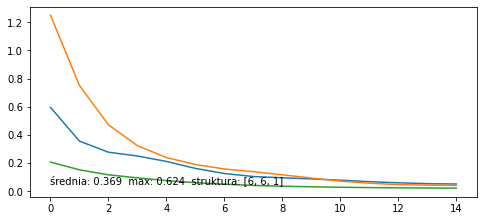

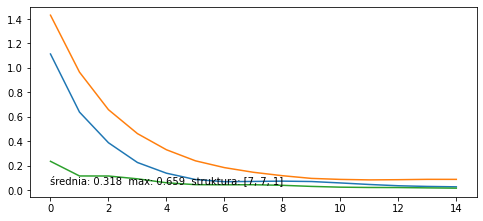

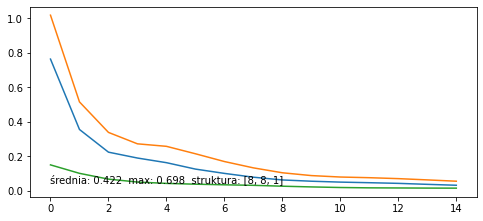

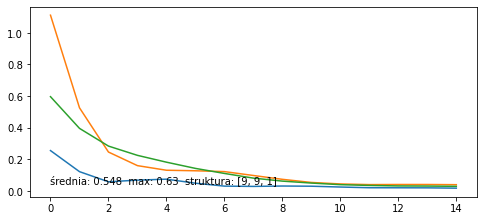

In [ ]:
test_.compute(X_train, y_train, epochs = 15, validation_split = 0.2, shuffle = True, verbose=0)

##### boxplot

In [ ]:
# + boxplot version
# for checking the distribution

def net1_(NEURONS: int) -> tf.keras.Model:
    model = keras.models.Sequential()
    model.add(keras.layers.Dense(NEURONS, activation = 'relu', input_shape = (12,)))
    model.add(keras.layers.Dense(NEURONS, activation = 'relu'))
    model.add(keras.layers.Dense(1))
    optimizer = keras.optimizers.Adam(learning_rate = 0.01, beta_1=0.9, beta_2 = 0.999)
    model.compile(loss = "MSE",
                 optimizer = optimizer,
                 metrics = ["MAE"])
    return model

                    
class plot_train_via_neurons:
    def __init__(self, NET:tf.keras.Model, scaler, full_ds: tuple):
        assert isinstance(NET(1), tf.keras.Model), "No keras model"      #added 1 to NET in oder to check return by fun type
        self.net_ = NET
        self.input_scaler = scaler
        self.full_ds = full_ds
        self.ttt = []
        self.zzz = []

    def _struc(self):
        len_ = range(len(self.model.get_config()['layers'])-1)
        out = [self.model.layers[x].units for x in len_]
        return out
    
    def compute(self,*args, **kwargs):
        for NEURONS in [6,7,8,9]:
            lista = []
            plt.figure(figsize=(8, 3.5))
            for _ in range(3):
                self.model = self.net_(NEURONS)
                history = self.model.fit(*args,**kwargs)
    
                # METRICS
                y_pred_ = np.ravel(self.model.predict(self.input_scaler.transform(self.full_ds[0])))     
                y_true_ = np.ravel(self.full_ds[1])                                                     
                wynik = measures.pearsonr(y_pred_, y_true_)[0] #.round(2)
                lista.append(wynik)
                plt.plot(history.history['loss'])
                #plt.plot(history.history['val_loss'], '--')
                tf.keras.backend.clear_session()
            print(lista, 'średnia: ', np.mean(lista).round(3), 'max: ', np.max(lista).round(3), 'struktura: ', self._struc())
    
            now = datetime.now()
            current_time = now.strftime("%H_%M_%S")
            plt.text(0,0.05, s = "średnia: {}  max: {}  struktura: {}".format(np.mean(lista).round(3),np.max(lista).round(3),self._struc()) )
            plt.savefig('{}'.format(current_time))
            
            self.ttt.append(lista)
            self.zzz.append(str(self._struc()))
    def plot_box(self):
        plt.boxplot(self.ttt, labels = self.zzz)

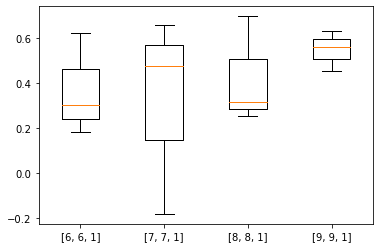

In [ ]:
test_.plot_box() 

In [ ]:
#warning, manual set n neurons,
class checker_dist_box(plot_train_via_neurons):
    def __init__(self,NET, scaler, full_ds):
        super().__init__(NET, scaler, full_ds)

    def compute(self,*args, **kwargs):
        neurons = kwargs.pop("neurons")  
        lista = []
        plt.figure(figsize=(8, 3.5))
        for _ in range(10):
            self.model = self.net_(neurons)         # set n neurons
            self.model.fit(*args,**kwargs)
            y_pred_ = np.ravel(self.model.predict(self.input_scaler.transform(self.full_ds[0])))     
            y_true_ = np.ravel(self.full_ds[1])                                                     
            wynik = measures.pearsonr(y_pred_, y_true_)[0] #.round(2)
            lista.append(wynik)
            tf.keras.backend.clear_session()
        print(
            lista, 
            'średnia: ', np.mean(lista).round(3), 
            'max: ', np.max(lista).round(3), 
            'struktura: ', self._struc(), 
            ' !Coef Pearson'
            )
        self.ttt.append(lista)
        self.zzz.append(str(self._struc()))

    @property
    def plot_box(self):
        plt.boxplot(self.ttt, labels = self.zzz)

In [ ]:
test1 = checker_dist_box(net1_, scalerMinMax, (data_p, CRFp))

In [ ]:
test1.compute(
    X_train, y_train, 
    epochs = 15, 
    validation_split = 0.2, 
    shuffle = True, 
    verbose=0,
    neurons = 3
    )

[0.15432124005243916, 0.4223900986783363, 0.3199089433286312, 0.39635989841025965, 0.29451503755505404, -0.08159532638048461, 0.04907380572673374, 0.5017050129194488, -0.19597923577208046, 0.3846141416087609] średnia:  0.225 max:  0.502 struktura:  [3, 3, 1]  !Coef Pearson


<Figure size 576x252 with 0 Axes>

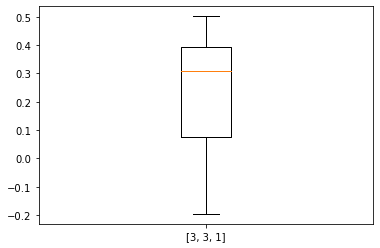

In [ ]:
test1.plot_box